# Librerias necesarias

In [1694]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    RidgeCV,
    ElasticNetCV,
    LassoCV,
    SGDRegressor,
    LogisticRegression
)
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
     mean_squared_error, 
     r2_score, 
     mean_absolute_error,
     classification_report, 
     confusion_matrix,
     ConfusionMatrixDisplay,
     balanced_accuracy_score, 
     log_loss,
     roc_curve, 
     roc_auc_score, 
     auc,
     accuracy_score
)
import shap
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import f1_score as sklearn_f1_score
import tensorflow as tf
import optuna
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Carga de datos

In [1695]:
file_path = "weatherAUS.csv"
df = pd.read_csv(file_path, sep=",", engine="python")

# Limpieza y transformacion de datos

1) Elimino la columna 'Unnamed: 0' porque es un indice que esta de mas.
2) Segun el enunciado, unicamente nos interesan las ciudades Adelaide, Canberra, Cobar, Dartmoor, Melbourne, MelbourneAirport, MountGambier, Sydney y SydneyAirport por lo que filtro el DataSet para quedarme unicamente con los datos de dichas ciudades.

3) Elimino de una vez la variable 'Location' debido a que el enunicado declara que se pueden considerar como una unica ubicacion.

In [1696]:
df = df.drop("Unnamed: 0", axis=1)
ciudades = [
    " Adelaide",
    "Canberra",
    "Cobar",
    "Dartmoor",
    "Melbourne",
    "MelbourneAirport",
    "MountGambier",
    "Sydney",
    "SydneyAirport",
]
df = df[df["Location"].isin(ciudades)]
df = df.drop("Location", axis=1)

---

## Split de datos

Hago el split en df_train y df_test a partir de una fecha determinada para dejar aproximadamente un 80% de mis datos en Train y 20% en Test.

La fecha mas antigua del dataset es 01-11-2007 y la mas reciente es 24-06-2017. 
Decido hacer el split de datos a partir de la fecha 01-01-2016, concentrando aproximadamente el 80% de datos para el conjunto de entrenamiento, y el 20% restante para el conjunto de test.

In [1697]:
df["Date"] = pd.to_datetime(df["Date"])

fecha_mas_antigua = df['Date'].min()
fecha_mas_reciente = df['Date'].max()

print(f'Fecha mas antigua: {fecha_mas_antigua}')
print(f'Fecha mas reciente: {fecha_mas_reciente}')

Fecha mas antigua: 2007-11-01 00:00:00
Fecha mas reciente: 2017-06-24 00:00:00


In [1698]:
fecha_limite = "2016-01-01"

df_train = df[df["Date"] < fecha_limite]

df_test = df[df["Date"] >= fecha_limite]

print("Tamaño del conjunto de entrenamiento:", len(df_train))
print("Tamaño del conjunto de prueba:", len(df_test))

Tamaño del conjunto de entrenamiento: 20713
Tamaño del conjunto de prueba: 4328


---

## Tipos de datos y valores nulos

Observo una descripcion, el tipo de dato y los valores nulos de cada variable.

In [1699]:
df_train.describe()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,20713,20271.000000,20284.000000,19981.000000,19461.000000,17369.000000,19159.000000,20366.000000,20382.000000,20023.000000,20068.000000,20008.000000,20016.000000,15867.000000,15593.000000,20258.000000,20265.000000,19981.000000
mean,2012-04-24 22:18:46.596823040,10.955991,21.647510,2.062940,4.675207,6.809471,42.885015,15.986252,20.811500,69.661489,50.862916,1018.303134,1016.178991,4.572761,4.687616,15.168388,20.142990,2.061859
min,2007-11-01 00:00:00,-8.000000,4.100000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,5.000000,1.000000,986.700000,985.500000,0.000000,0.000000,-1.300000,3.700000,0.000000
25%,2010-06-10 00:00:00,7.100000,16.500000,0.000000,2.200000,3.700000,33.000000,9.000000,15.000000,58.000000,37.000000,1013.400000,1011.300000,1.000000,2.000000,11.100000,15.200000,0.000000
50%,2012-04-17 00:00:00,10.600000,20.800000,0.000000,4.000000,7.300000,41.000000,15.000000,20.000000,71.000000,50.000000,1018.500000,1016.300000,6.000000,6.000000,14.700000,19.300000,0.000000
75%,2014-03-24 00:00:00,14.900000,25.800000,1.000000,6.400000,10.000000,52.000000,20.000000,26.000000,83.000000,64.000000,1023.400000,1021.200000,7.000000,7.000000,18.900000,24.200000,1.000000
max,2015-12-31 00:00:00,30.500000,46.800000,119.400000,64.800000,14.300000,122.000000,69.000000,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,37.700000,46.100000,119.400000
std,NaN,5.741061,6.573869,6.446013,3.401770,3.853102,14.462229,9.778937,9.218541,18.437859,20.014269,7.370028,7.236090,2.814362,2.619433,5.655393,6.410891,6.445336


In [1700]:
df_train.dtypes

Date                datetime64[ns]
MinTemp                    float64
MaxTemp                    float64
Rainfall                   float64
Evaporation                float64
Sunshine                   float64
WindGustDir                 object
WindGustSpeed              float64
WindDir9am                  object
WindDir3pm                  object
WindSpeed9am               float64
WindSpeed3pm               float64
Humidity9am                float64
Humidity3pm                float64
Pressure9am                float64
Pressure3pm                float64
Cloud9am                   float64
Cloud3pm                   float64
Temp9am                    float64
Temp3pm                    float64
RainToday                   object
RainTomorrow                object
RainfallTomorrow           float64
dtype: object

In [1701]:
df_train.isnull().sum()

Date                   0
MinTemp              442
MaxTemp              429
Rainfall             732
Evaporation         1252
Sunshine            3344
WindGustDir         1557
WindGustSpeed       1554
WindDir9am          1229
WindDir3pm           401
WindSpeed9am         347
WindSpeed3pm         331
Humidity9am          690
Humidity3pm          645
Pressure9am          705
Pressure3pm          697
Cloud9am            4846
Cloud3pm            5120
Temp9am              455
Temp3pm              448
RainToday            732
RainTomorrow         732
RainfallTomorrow     732
dtype: int64

Observo que las variables 'RainToday', 'RainTomorrow' y 'RainfallTomorrow' tienen igual cantidad de valores nulos.

Me fijo en que registros las tres columnas son nulas, son unicamente 570 registros, lo que representa aproximadamente un 2% de mi dataset, por lo que decido eliminarlos.

In [1702]:
# Registros de df_train donde las 3 variables son Nulas.
df_train[
    df_train["RainToday"].isnull()
    & df_train["RainTomorrow"].isnull()
    & df_train["RainfallTomorrow"].isnull()
]

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6967,2011-08-09,7.4,13.0,NaN,NaN,NaN,WNW,28.0,WSW,W,...,51.0,1013.0,1011.1,8.0,7.0,8.2,12.5,NaN,NaN,NaN
6968,2011-08-10,6.5,16.7,NaN,NaN,NaN,WSW,26.0,NNW,W,...,64.0,1010.5,1007.7,NaN,8.0,11.4,12.7,NaN,NaN,NaN
7445,2012-11-29,23.9,41.7,NaN,11.2,NaN,SW,50.0,NNE,NNW,...,16.0,1011.5,1008.4,1.0,4.0,29.8,40.9,NaN,NaN,NaN
32570,2014-11-28,NaN,23.3,NaN,3.4,11.9,ENE,37.0,E,E,...,46.0,NaN,1021.3,3.0,2.0,NaN,22.3,NaN,NaN,NaN
46854,2011-06-04,4.4,13.2,NaN,2.2,0.6,NaN,NaN,NNW,WNW,...,58.0,NaN,NaN,8.0,NaN,10.6,11.9,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81030,2009-02-28,NaN,NaN,NaN,8.0,4.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81031,2009-03-01,NaN,NaN,NaN,4.0,6.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81032,2009-03-02,NaN,NaN,NaN,3.8,9.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81033,2009-03-03,NaN,NaN,NaN,8.0,1.9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1703]:
df_train = df_train[
    ~(
        df_train["RainToday"].isnull()
        & df_train["RainTomorrow"].isnull()
        & df_train["RainfallTomorrow"].isnull()
    )
]

In [1704]:
print("Nulos RainToday:", df_train["RainToday"].isnull().sum())
print("Nulos RainTomorrow:", df_train["RainTomorrow"].isnull().sum())
print("Nulos RainfallTomorrow:", df_train["RainfallTomorrow"].isnull().sum())

Nulos RainToday: 162
Nulos RainTomorrow: 162
Nulos RainfallTomorrow: 162


En cada variable quedaron un total de 162 nulos, vuelvo a observar pero esta vez de a pares, en que variables hay nulos a la vez.

In [1705]:
print(
    "Nulos RainToday y RainTomorrow:",
    (df_train["RainToday"].isnull() & df_train["RainTomorrow"].isnull()).sum(),
)
print(
    "Nulos RainToday y RainfallTomorrow:",
    (df_train["RainToday"].isnull() & df_train["RainfallTomorrow"].isnull()).sum(),
)
print(
    "Nulos RainTomorrow y RainfallTomorrow:",
    (df_train["RainTomorrow"].isnull() & df_train["RainfallTomorrow"].isnull()).sum(),
)

Nulos RainToday y RainTomorrow: 0
Nulos RainToday y RainfallTomorrow: 0
Nulos RainTomorrow y RainfallTomorrow: 162


Procedo a eliminar los registros nulos de las variables 'RainTomorrow' y 'RainfallTomorrow'.

In [1706]:
df_train[df_train["RainTomorrow"].isnull() & df_train["RainfallTomorrow"].isnull()]

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6292,2009-09-03,12.0,23.8,0.0,6.4,NaN,N,41.0,NNE,NNW,...,38.0,1016.3,1013.3,7.0,3.0,17.1,22.2,No,NaN,NaN
6966,2011-08-08,3.5,16.0,0.0,4.6,NaN,W,44.0,W,W,...,39.0,1014.7,1011.7,7.0,5.0,9.1,15.4,No,NaN,NaN
7444,2012-11-28,19.5,38.0,2.0,NaN,NaN,NaN,NaN,NaN,NNW,...,25.0,NaN,1010.0,2.0,2.0,26.6,36.6,Yes,NaN,NaN
31035,2010-06-18,9.8,18.0,0.6,3.0,9.6,NaN,NaN,W,W,...,39.0,1017.1,1015.5,NaN,NaN,12.1,17.8,No,NaN,NaN
31148,2010-10-09,15.8,18.9,0.0,5.2,0.0,ESE,31.0,ESE,ENE,...,55.0,1026.4,1025.3,NaN,NaN,17.0,18.3,No,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69427,2014-11-24,15.7,19.9,2.0,7.8,0.4,N,63.0,WSW,SW,...,88.0,1009.1,1006.5,7.0,NaN,17.5,18.3,Yes,NaN,NaN
69437,2014-12-04,17.6,27.7,8.6,1.8,11.8,SSE,35.0,SE,SSE,...,54.0,1010.2,1008.1,7.0,6.0,20.8,25.9,Yes,NaN,NaN
69453,2014-12-20,12.6,23.8,0.0,5.4,13.4,S,35.0,SSW,ESE,...,41.0,1019.3,1017.5,NaN,NaN,16.4,22.4,No,NaN,NaN
69470,2015-01-06,17.6,NaN,0.0,6.6,11.6,S,35.0,ENE,SSE,...,NaN,1020.2,NaN,3.0,NaN,20.7,NaN,No,NaN,NaN


In [1707]:
df_train = df_train[
    ~(df_train["RainTomorrow"].isnull() & df_train["RainfallTomorrow"].isnull())
]

## Correlacion de variables

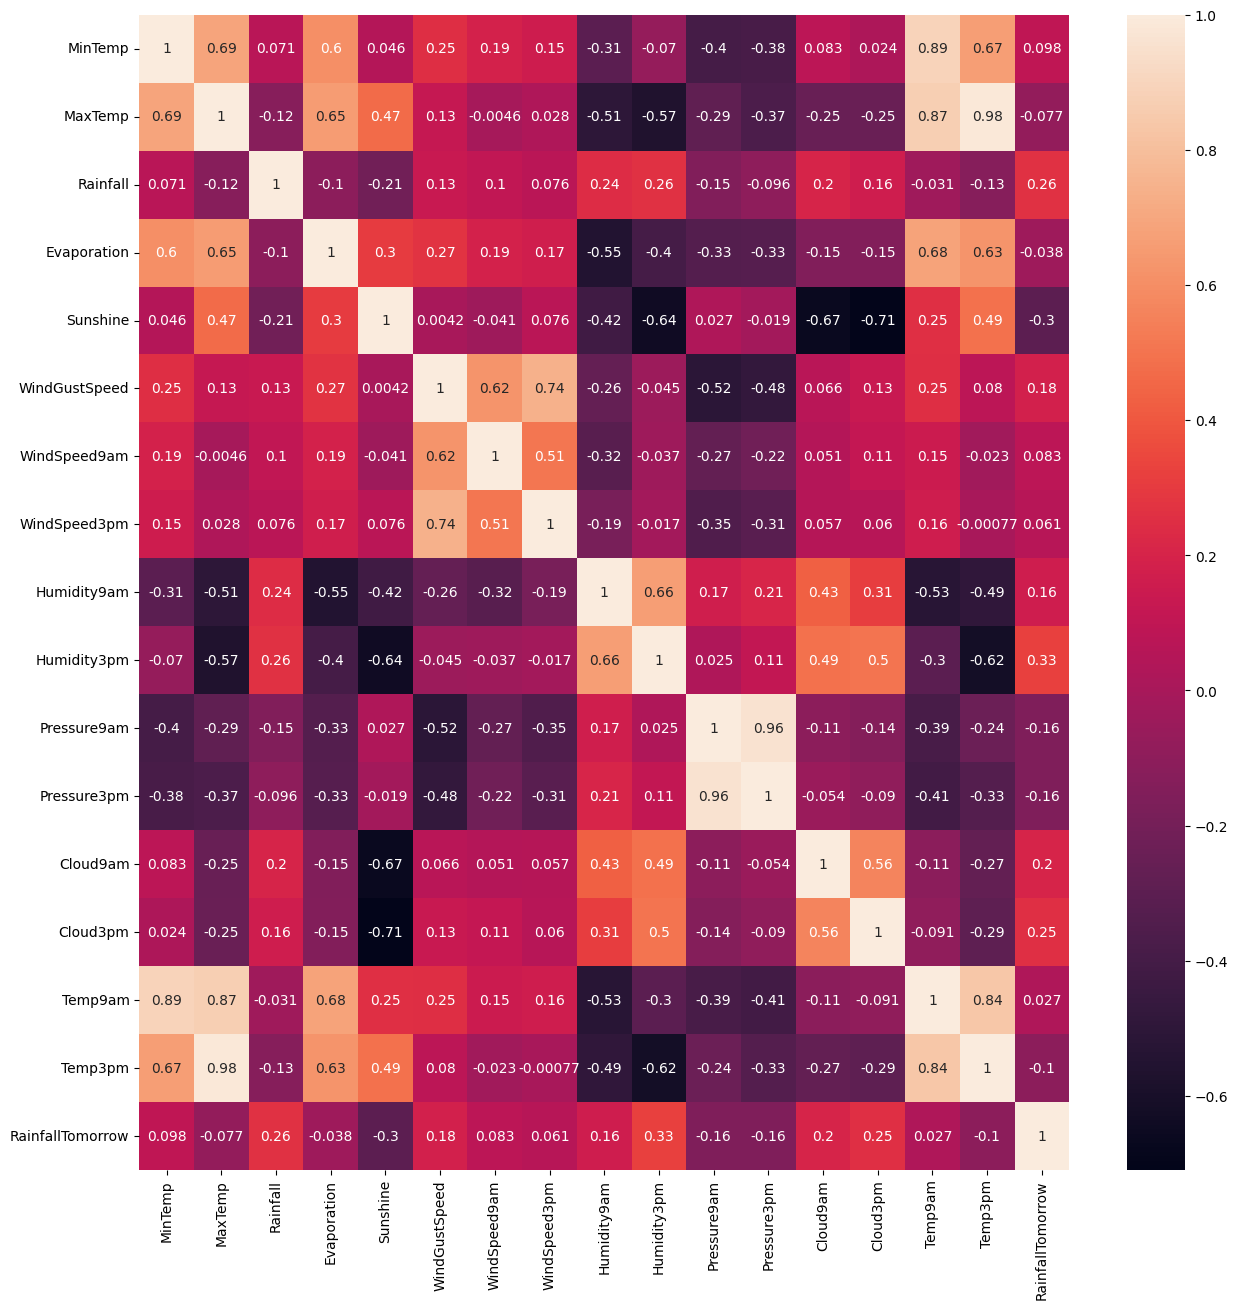

In [1708]:
plt.figure(figsize=(15, 15))
sns.heatmap(
    df_train[
        [
            "MinTemp",
            "MaxTemp",
            "Rainfall",
            "Evaporation",
            "Sunshine",
            "WindGustSpeed",
            "WindSpeed9am",
            "WindSpeed3pm",
            "Humidity9am",
            "Humidity3pm",
            "Pressure9am",
            "Pressure3pm",
            "Cloud9am",
            "Cloud3pm",
            "Temp9am",
            "Temp3pm",
            "RainfallTomorrow",
        ]
    ].corr(),
    annot=True,
)
plt.show()

**Correlaciones Altas:**

* Temperatura: Temp9am, Temp3pm, y MaxTemp están fuertemente correlacionadas, lo que puede ser porque miden aspectos similares del clima diario.
* Presión: Pressure9am y Pressure3pm tienen una correlación muy alta.

**Correlaciones Negativas Fuertes:**
* Cloud3pm y Sunshine muestran que más nubes en la tarde reducen la luz solar.
* Humedad y Luz Solar: Humidity3pm y Sunshine también están inversamente relacionadas.

**Relación con RainfallTomorrow:**
Las variables relacionadas con la humedad y la nubosidad en la tarde parecen ser buenos indicadores para predecir la lluvia del día siguiente.
* Humedad en la tarde (Humidity3pm) y nubosidad en la tarde (Cloud3pm) tienen correlaciones moderadas positivas con la lluvia del día siguiente.


---

## Imputacion de valores faltantes

### Rainfall

In [1709]:
print(df_train["Rainfall"].isnull().sum())

162


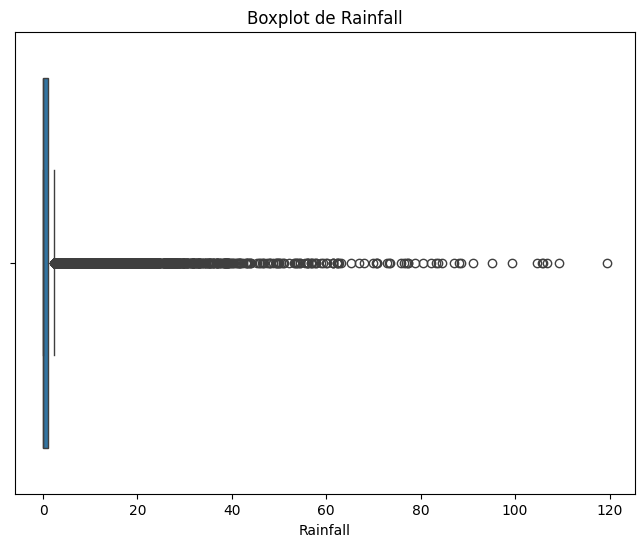

In [1710]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="Rainfall", data=df_train)
plt.title("Boxplot de Rainfall")
plt.show()

Veo una gran presencia de valores Outliers por lo que me inclino a usar la Mediana como medida para rellenar los valores nulos de la variable RainFall

In [1711]:
# df_train
mediana_Rainfall_train = df_train.groupby('Date')['Rainfall'].median()
df_train['Rainfall'] = df_train.apply(lambda x: mediana_Rainfall_train[x['Date']] if pd.isnull(x['Rainfall']) else x['Rainfall'], axis=1)

# df_test
mediana_Rainfall_test = df_test.groupby('Date')['Rainfall'].median()
df_test['Rainfall'] = df_test.apply(lambda x: mediana_Rainfall_test[x['Date']] if pd.isnull(x['Rainfall']) else x['Rainfall'], axis=1)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\3045500574.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Rainfall'] = df_test.apply(lambda x: mediana_Rainfall_test[x['Date']] if pd.isnull(x['Rainfall']) else x['Rainfall'], axis=1)


---

### Evaporation

In [1712]:
print(df_train["Evaporation"].isnull().sum())

1240


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


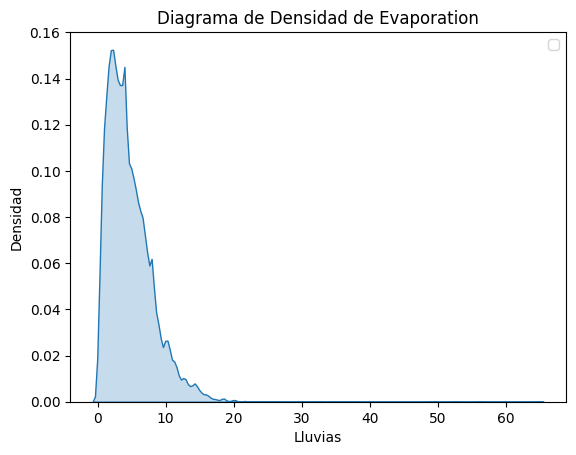

In [1713]:
bandwidth = 0.5
sns.kdeplot(data=df_train['Evaporation'], fill=True, bw_adjust=bandwidth)
plt.title('Diagrama de Densidad de Evaporation')
plt.xlabel('Lluvias')
plt.ylabel('Densidad')
plt.legend()

Nuevamente observo una fuerte presencia de valores outliers por lo que voy a usar la **Mediana** para imputar valores faltantes.

In [1714]:
# df_train
mediana_Evaporation_train = df_train.groupby('Date')['Evaporation'].median()
df_train['Evaporation'] = df_train.apply(lambda x: mediana_Evaporation_train[x['Date']] if pd.isnull(x['Evaporation']) else x['Evaporation'], axis=1)

# df_test
mediana_Evaporation_test = df_test.groupby('Date')['Evaporation'].median()
df_test['Evaporation'] = df_test.apply(lambda x: mediana_Evaporation_test[x['Date']] if pd.isnull(x['Evaporation']) else x['Evaporation'], axis=1)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\2678679043.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Evaporation'] = df_test.apply(lambda x: mediana_Evaporation_test[x['Date']] if pd.isnull(x['Evaporation']) else x['Evaporation'], axis=1)


---

### Sunshine

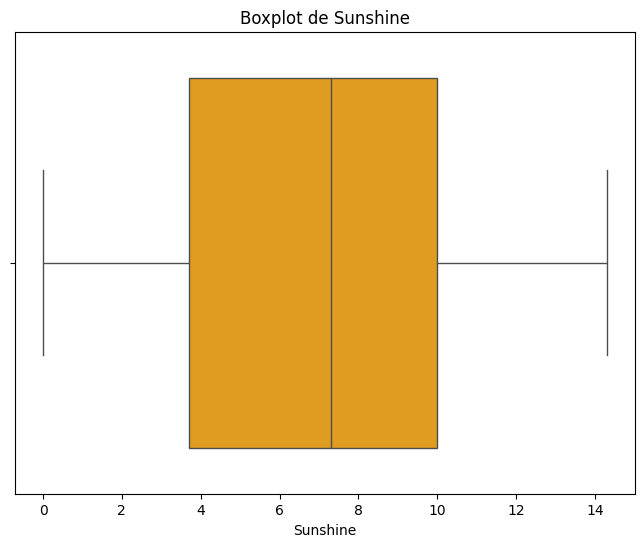

In [1715]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="Sunshine", data=df_train, color="orange")
plt.title("Boxplot de Sunshine")
plt.show()

La distribucion de la variable Sunshine se ve bastante balanceada y sin presencia de outliers por lo que utilizo la **Media** para imputar a los valores nulos.

In [1716]:
df_train["Sunshine"] = df_train.groupby(df_train["Date"].dt.day)["Sunshine"].transform(
    lambda x: x.fillna(x.mean())
)
df_test["Sunshine"] = df_train.groupby(df_train["Date"].dt.day)["Sunshine"].transform(
    lambda x: x.fillna(x.mean())
)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\2290878809.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["Sunshine"] = df_train.groupby(df_train["Date"].dt.day)["Sunshine"].transform(


In [1717]:
# Extraigo el mes de la columna 'Date'
df_train['Month'] = df_train['Date'].dt.month
df_test['Month'] = df_test['Date'].dt.month

# Calcular la media de MinTemp por mes en df_train
media_Sunshine_mes_train = df_train.groupby('Month')['Sunshine'].mean()

C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\1681817379.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Month'] = df_test['Date'].dt.month


In [1718]:
# Imputar los valores nulos de Sunshine de df_test con la media por mes
# Sunshine
df_train['Sunshine'] = df_train['Sunshine'].fillna(df_train['Month'].map(media_Sunshine_mes_train))
df_test['Sunshine'] = df_test['Sunshine'].fillna(df_test['Month'].map(media_Sunshine_mes_train))

C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\2389355344.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Sunshine'] = df_test['Sunshine'].fillna(df_test['Month'].map(media_Sunshine_mes_train))


---

### WindGustDir, WindDir9am y WindDir3pm

In [1719]:
print(df_train["WindGustDir"].isnull().sum())
print(df_train["WindDir9am"].isnull().sum())
print(df_train["WindDir3pm"].isnull().sum())

1482
1149
338


In [1720]:
# Registros donde las 3 variables son Nulas
df_train[
    df_train["WindGustDir"].isnull()
    & df_train["WindDir9am"].isnull()
    & df_train["WindDir3pm"].isnull()
]

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow,Month
7867,2014-03-25,11.0,27.8,0.0,2.8,6.859300,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,2.0,15.8,25.9,No,No,0.0,3
7990,2014-07-26,NaN,NaN,0.0,3.4,6.733883,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,No,No,0.0,7
7991,2014-07-27,NaN,18.9,0.0,4.1,6.682633,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,1.0,NaN,NaN,No,No,0.0,7
7997,2014-08-02,NaN,13.7,0.0,5.4,6.872711,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,1.0,NaN,NaN,No,No,0.0,8
8019,2014-08-24,8.9,22.2,0.0,3.8,6.688376,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,2.0,15.2,21.2,No,No,0.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101491,2014-08-31,9.2,20.0,0.0,3.6,0.500000,NaN,NaN,NaN,NaN,...,1014.1,1009.9,7.0,8.0,13.8,18.5,No,Yes,4.6,8
101526,2014-10-05,8.7,17.8,0.0,6.0,8.900000,NaN,NaN,NaN,NaN,...,1018.3,1015.7,7.0,1.0,12.9,17.1,No,Yes,1.4,10
101553,2014-11-01,8.9,14.4,3.8,10.2,10.400000,NaN,83.0,NaN,NaN,...,1008.4,1013.6,5.0,6.0,12.5,13.6,Yes,Yes,1.2,11
101561,2014-11-09,6.1,20.2,1.2,2.6,11.900000,NaN,NaN,NaN,NaN,...,1025.1,1022.9,5.0,1.0,14.2,19.0,Yes,No,0.0,11


Relleno los valores faltantes para cada variable utilizando la **Moda** de cada dia.

In [1721]:
# df_train
df_train["WindGustDir"] = df_train.groupby(df_train["Date"].dt.day)[
    "WindGustDir"
].transform(lambda x: x.fillna(x.mode().iloc[0]))
df_train["WindDir9am"] = df_train.groupby(df_train["Date"].dt.day)[
    "WindDir9am"
].transform(lambda x: x.fillna(x.mode().iloc[0]))
df_train["WindDir3pm"] = df_train.groupby(df_train["Date"].dt.day)[
    "WindDir3pm"
].transform(lambda x: x.fillna(x.mode().iloc[0]))

# df_test
df_test["WindGustDir"] = df_test.groupby(df_test["Date"].dt.day)[
    "WindGustDir"
].transform(lambda x: x.fillna(x.mode().iloc[0]))
df_test["WindDir9am"] = df_test.groupby(df_test["Date"].dt.day)["WindDir9am"].transform(
    lambda x: x.fillna(x.mode().iloc[0])
)
df_test["WindDir3pm"] = df_test.groupby(df_test["Date"].dt.day)["WindDir3pm"].transform(
    lambda x: x.fillna(x.mode().iloc[0])
)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\132721561.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["WindGustDir"] = df_test.groupby(df_test["Date"].dt.day)[
C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\132721561.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["WindDir9am"] = df_test.groupby(df_test["Date"].dt.day)["WindDir9am"].transform(
C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\132721561.py:19: SettingWithCopyWarning: 
A value is trying to be set

In [1722]:
print(df_train["WindGustDir"].isnull().sum())
print(df_train["WindDir9am"].isnull().sum())
print(df_train["WindDir3pm"].isnull().sum())

0
0
0


---

### WindGustSpeed, WindSpeed9am y WindSpeed3pm

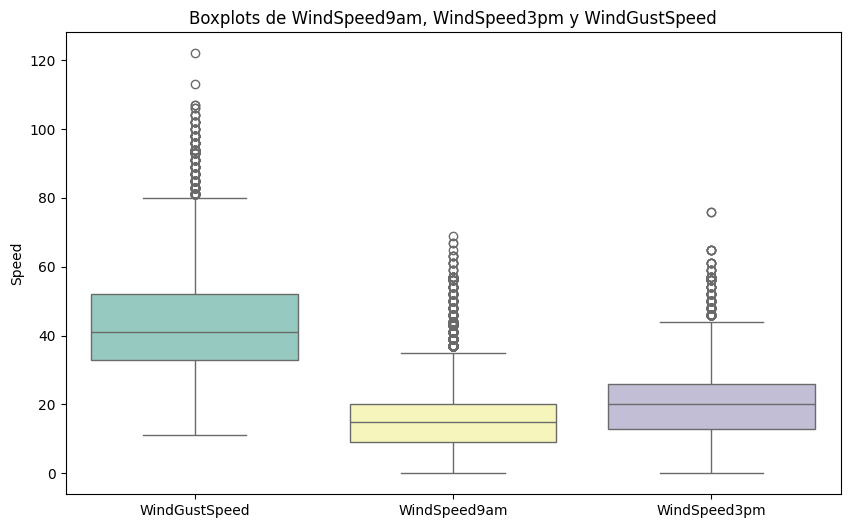

In [1723]:
data_to_plot = df_train[["WindGustSpeed", "WindSpeed9am", "WindSpeed3pm"]]

plt.figure(figsize=(10, 6))
sns.boxplot(data=data_to_plot, palette="Set3")
plt.title("Boxplots de WindSpeed9am, WindSpeed3pm y WindGustSpeed")
plt.ylabel("Speed")
plt.show()

Voy a imputar los valores nulos utilizando la **Mediana** por dia.

In [1724]:
df_train["WindGustSpeed"] = df_train.groupby(df_train["Date"].dt.day)[
    "WindGustSpeed"
].transform(lambda x: x.fillna(x.median()))
df_train["WindSpeed9am"] = df_train.groupby(df_train["Date"].dt.day)[
    "WindSpeed9am"
].transform(lambda x: x.fillna(x.median()))
df_train["WindSpeed3pm"] = df_train.groupby(df_train["Date"].dt.day)[
    "WindGustSpeed"
].transform(lambda x: x.fillna(x.median()))


df_test["WindGustSpeed"] = df_test.groupby(df_test["Date"].dt.day)[
    "WindGustSpeed"
].transform(lambda x: x.fillna(x.median()))
df_test["WindSpeed9am"] = df_test.groupby(df_test["Date"].dt.day)[
    "WindSpeed9am"
].transform(lambda x: x.fillna(x.median()))
df_test["WindSpeed3pm"] = df_test.groupby(df_test["Date"].dt.day)[
    "WindGustSpeed"
].transform(lambda x: x.fillna(x.median()))

C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\3221081509.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["WindGustSpeed"] = df_test.groupby(df_test["Date"].dt.day)[
C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\3221081509.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["WindSpeed9am"] = df_test.groupby(df_test["Date"].dt.day)[
C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\3221081509.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [1725]:
print(df_train["WindGustSpeed"].isnull().sum())
print(df_train["WindSpeed9am"].isnull().sum())
print(df_train["WindSpeed3pm"].isnull().sum())

0
0
0


---

### Humidity9am, Humidity3pm, Cloud9am, Cloud3pm, Pressure9am y Pressure3pm

In [1726]:
print(df_train["Humidity9am"].isnull().sum())
print(df_train["Humidity3pm"].isnull().sum())
print(df_train["Cloud9am"].isnull().sum())
print(df_train["Cloud3pm"].isnull().sum())
print(df_train["Pressure9am"].isnull().sum())
print(df_train["Pressure3pm"].isnull().sum())

265
222
4267
4527
279
273


#### Humidity9am y Humidity3pm

Imputo los valores de **Humidity9am** y **Humidity3pm** con la mediana por fecha

In [1727]:
# df_train
mediana_Humidity9am = df_train.groupby('Date')['Humidity9am'].median()
df_train['Humidity9am'] = df_train.apply(lambda x: mediana_Humidity9am[x['Date']] if pd.isnull(x['Humidity9am']) else x['Humidity9am'], axis=1)

mediana_Humidity3pm = df_train.groupby('Date')['Humidity3pm'].median()
df_train['Humidity3pm'] = df_train.apply(lambda x: mediana_Humidity3pm[x['Date']] if pd.isnull(x['Humidity3pm']) else x['Humidity3pm'], axis=1)

# df_test
mediana_Humidity9am_test = df_test.groupby('Date')['Humidity9am'].median()
df_test['Humidity9am'] = df_test.apply(lambda x: mediana_Humidity9am_test[x['Date']] if pd.isnull(x['Humidity9am']) else x['Humidity9am'], axis=1)

mediana_Humidity3pm_test = df_test.groupby('Date')['Humidity3pm'].median()
df_test['Humidity3pm'] = df_test.apply(lambda x: mediana_Humidity3pm_test[x['Date']] if pd.isnull(x['Humidity3pm']) else x['Humidity3pm'], axis=1)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\181873114.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Humidity9am'] = df_test.apply(lambda x: mediana_Humidity9am_test[x['Date']] if pd.isnull(x['Humidity9am']) else x['Humidity9am'], axis=1)
C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\181873114.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Humidity3pm'] = df_test.apply(lambda x: mediana_Humidity3pm_test[x['Date']] if pd.isnull(x['Humidity3pm']) else x['Humidit

In [1728]:
print(df_train["Humidity9am"].isnull().sum())
print(df_train["Humidity3pm"].isnull().sum())

0
0


#### Cloud9am y Cloud3pm

Hago lo mismo con Cloud9am y Cloud3pm, usando las mediana por dia para imputar valores faltantes.

In [1729]:
# df_train
mediana_Cloud9am = df_train.groupby('Date')['Cloud9am'].median()
df_train['Cloud9am'] = df_train.apply(lambda x: mediana_Cloud9am[x['Date']] if pd.isnull(x['Cloud9am']) else x['Cloud9am'], axis=1)

mediana_Cloud3pm = df_train.groupby('Date')['Cloud3pm'].median()
df_train['Cloud3pm'] = df_train.apply(lambda x: mediana_Cloud3pm[x['Date']] if pd.isnull(x['Cloud3pm']) else x['Cloud3pm'], axis=1)

# df_test
mediana_Cloud9am_test = df_test.groupby('Date')['Cloud9am'].median()
df_test['Cloud9am'] = df_test.apply(lambda x: mediana_Cloud9am_test[x['Date']] if pd.isnull(x['Cloud9am']) else x['Cloud9am'], axis=1)

mediana_Cloud3pm_test = df_test.groupby('Date')['Cloud3pm'].median()
df_test['Cloud3pm'] = df_test.apply(lambda x: mediana_Cloud3pm_test[x['Date']] if pd.isnull(x['Cloud3pm']) else x['Cloud3pm'], axis=1)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\3635661414.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Cloud9am'] = df_test.apply(lambda x: mediana_Cloud9am_test[x['Date']] if pd.isnull(x['Cloud9am']) else x['Cloud9am'], axis=1)
C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\3635661414.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Cloud3pm'] = df_test.apply(lambda x: mediana_Cloud3pm_test[x['Date']] if pd.isnull(x['Cloud3pm']) else x['Cloud3pm'], axis=1)


In [1730]:
print(df_train["Cloud9am"].isnull().sum())
print(df_train["Cloud3pm"].isnull().sum())

0
0


#### Pressure9am y Pressure3pm

Repito la misma metodologia para las variables Pressure9am y Pressure3pm.

In [1731]:
# df_train
mediana_Pressure9am = df_train.groupby('Date')['Pressure9am'].median()
df_train['Pressure9am'] = df_train.apply(lambda x: mediana_Pressure9am[x['Date']] if pd.isnull(x['Pressure9am']) else x['Pressure9am'], axis=1)

mediana_Pressure3pm = df_train.groupby('Date')['Pressure3pm'].median()
df_train['Pressure3pm'] = df_train.apply(lambda x: mediana_Pressure3pm[x['Date']] if pd.isnull(x['Pressure3pm']) else x['Pressure3pm'], axis=1)

# df_test
mediana_Pressure9am_test = df_test.groupby('Date')['Pressure9am'].median()
df_test['Pressure9am'] = df_test.apply(lambda x: mediana_Pressure9am_test[x['Date']] if pd.isnull(x['Pressure9am']) else x['Pressure9am'], axis=1)

mediana_Pressure3pm_test = df_test.groupby('Date')['Pressure3pm'].median()
df_test['Pressure3pm'] = df_test.apply(lambda x: mediana_Pressure3pm_test[x['Date']] if pd.isnull(x['Pressure3pm']) else x['Pressure3pm'], axis=1)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\3146905465.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Pressure9am'] = df_test.apply(lambda x: mediana_Pressure9am_test[x['Date']] if pd.isnull(x['Pressure9am']) else x['Pressure9am'], axis=1)
C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\3146905465.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Pressure3pm'] = df_test.apply(lambda x: mediana_Pressure3pm_test[x['Date']] if pd.isnull(x['Pressure3pm']) else x['Press

In [1732]:
print(df_train["Pressure9am"].isnull().sum())
print(df_train["Pressure3pm"].isnull().sum())

0
0


---

### MinTemp, MaxTemp, Temp9am y Temp3pm

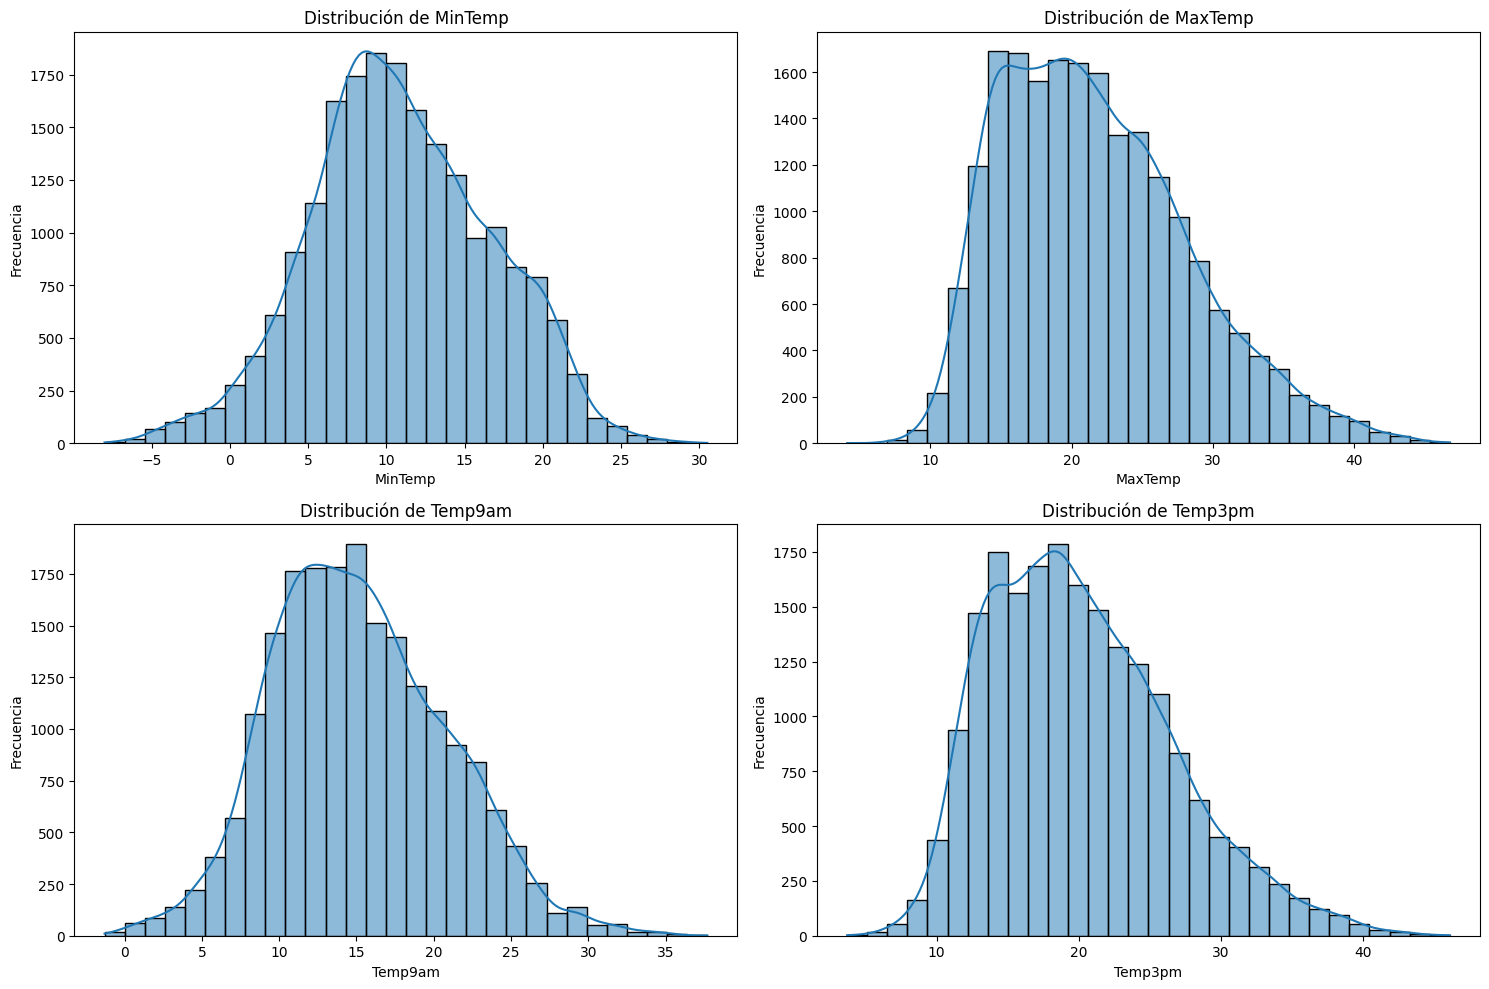

In [1733]:
# Seleccionar algunas columnas para analizar
columns = ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']

# Crear la figura y los subgráficos
plt.figure(figsize=(15, 10))

for i, column in enumerate(columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_train[column], bins=30, kde=True)
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Observo una distribucion bastante normal en las 4 variables, por lo que en este caso voy a optar por imputar los valores faltantes utilizando la **Media**.

Para eso, voy a calcular la media de cada variable por mes en mi df_train y luego usar estos valores para imputar los valores faltantes tanto en mi df_train como df_test.

In [1734]:
# Extraigo el mes de la columna 'Date'
df_train['Month'] = df_train['Date'].dt.month
df_test['Month'] = df_test['Date'].dt.month

# Calcular la media de MinTemp por mes en df_train
media_MinTemp_mes_train = df_train.groupby('Month')['MinTemp'].mean()
media_MaxTemp_mes_train = df_train.groupby('Month')['MaxTemp'].mean()
media_Temp9am_mes_train = df_train.groupby('Month')['Temp9am'].mean()
media_Temp3pm_mes_train = df_train.groupby('Month')['Temp3pm'].mean()

C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\530622026.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Month'] = df_test['Date'].dt.month


In [1735]:
# Imputar los valores nulos de MinTemp de df_test con la media por mes
# MinTemp
df_train['MinTemp'] = df_train['MinTemp'].fillna(df_train['Month'].map(media_MinTemp_mes_train))
df_test['MinTemp'] = df_test['MinTemp'].fillna(df_test['Month'].map(media_MinTemp_mes_train))

# MaxTemp
df_train['MaxTemp'] = df_train['MaxTemp'].fillna(df_train['Month'].map(media_MaxTemp_mes_train))
df_test['MaxTemp'] = df_test['MaxTemp'].fillna(df_test['Month'].map(media_MaxTemp_mes_train))

# Temp9am
df_train['Temp9am'] = df_train['Temp9am'].fillna(df_train['Month'].map(media_Temp9am_mes_train))
df_test['Temp9am'] = df_test['Temp9am'].fillna(df_test['Month'].map(media_Temp9am_mes_train))

# Temp3pm
df_train['Temp3pm'] = df_train['Temp3pm'].fillna(df_train['Month'].map(media_Temp3pm_mes_train))
df_test['Temp3pm'] = df_test['Temp3pm'].fillna(df_test['Month'].map(media_Temp3pm_mes_train))

C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\4286069745.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['MinTemp'] = df_test['MinTemp'].fillna(df_test['Month'].map(media_MinTemp_mes_train))
C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\4286069745.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['MaxTemp'] = df_test['MaxTemp'].fillna(df_test['Month'].map(media_MaxTemp_mes_train))
C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\4286069745.py:12: SettingWithCopyWar

In [1736]:
# Elimino la columna 'Month' porque ya no la voy a usar mas
df_train.drop(columns=['Month'], inplace=True)
df_test.drop(columns=['Month'], inplace=True)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\1517116963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=['Month'], inplace=True)


---

### RainToday y RainTomorrow

In [1737]:
print(df_train["RainToday"].isna().sum())
print(df_train["RainTomorrow"].isna().sum())
print(df_train["RainfallTomorrow"].isna().sum())

162
0
0


Imputo los valores de RainToday con la moda porque es una variable categorica.

In [1738]:
# df_train
moda_RainToday_train = df_train.groupby("Date")["RainToday"].transform(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)
df_train["RainToday"] = df_train["RainToday"].fillna(moda_RainToday_train)

moda_RainToday_test = df_test.groupby("Date")["RainToday"].transform(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)
df_test["RainToday"] = df_test["RainToday"].fillna(moda_RainToday_test)

# df_test
moda_RainTomorrow_test = df_test.groupby("Date")["RainTomorrow"].transform(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)
df_test["RainTomorrow"] = df_test["RainTomorrow"].fillna(moda_RainTomorrow_test)

moda_RainfallTomorrow_test = df_test.groupby("Date")["RainfallTomorrow"].transform(
    lambda x: x.mode().iloc[0] if not x.mode().empty else None
)
df_test["RainfallTomorrow"] = df_test["RainfallTomorrow"].fillna(
    moda_RainfallTomorrow_test
)

C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\1132428338.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["RainToday"] = df_test["RainToday"].fillna(moda_RainToday_test)
C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\1132428338.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["RainTomorrow"] = df_test["RainTomorrow"].fillna(moda_RainTomorrow_test)
C:\Users\Francisco\AppData\Local\Temp\ipykernel_34424\1132428338.py:21: SettingWithCopyWarning: 
A value is trying to be se

---

### Comprobacion final

In [1739]:
df_train.isna().sum()

Date                0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
RainfallTomorrow    0
dtype: int64

In [1740]:
df_test.isna().sum()

Date                0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
RainfallTomorrow    0
dtype: int64

# Escalado de Datos

In [1741]:
columnas_categoricas = ['Date', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

In [1742]:
columnas_numericas = df_train.columns.difference(columnas_categoricas)
df_train_numeric = df_train[columnas_numericas]
df_test_numeric = df_test[columnas_numericas]

In [1743]:
scaler = StandardScaler()

# Ajustar el escalador solo con los datos numéricos de entrenamiento
scaler.fit(df_train_numeric)

# Escalo df_train
df_train_escalado_numeric = scaler.transform(df_train_numeric)
df_train_esc = pd.DataFrame(df_train_escalado_numeric, columns=columnas_numericas, index=df_train.index)

# Escalo df_test
df_test_escalado_numeric = scaler.transform(df_test_numeric)
df_test_esc = pd.DataFrame(df_test_escalado_numeric, columns=columnas_numericas, index=df_test.index)

# Uno las columnas categóricas con los df escalados
df_train_escalado = df_train[columnas_categoricas].join(df_train_esc)
df_test_escalado = df_test[columnas_categoricas].join(df_test_esc)

---

# Dummies

### RainToday y RainTomorrow

La columna 'RainToday' y 'RainTomorrow' tienen valores 'Yes' 'No' por lo que los mapeo a 1 para 'Yes' y 0 para 'No'.

In [1744]:
# df_train
df_train_escalado["RainToday"] = df_train_escalado["RainToday"].map({"Yes": 1, "No": 0})
df_train_escalado["RainTomorrow"] = df_train_escalado["RainTomorrow"].map({"Yes": 1, "No": 0})
# df_test
df_test_escalado["RainToday"] = df_test_escalado["RainToday"].map({"Yes": 1, "No": 0})
df_test_escalado["RainTomorrow"] = df_test_escalado["RainTomorrow"].map({"Yes": 1, "No": 0})

### WindGustDir, WindDir9am y WindDir3pm

Agrupo los valores de la variables categoricas de Direccion, que tiene los siguientes valores:

['SSW', 'S', 'SE', 'NNE', 'WNW', 'N', 'ENE', 'NE', 'E', 'SW', 'W', 'WSW', 'NNW', 'ESE', 'SSE', 'NW']

El criterio que empleo es asignar a cada punto cardenal el predominante, por ejemplo 'NNW' lo asigno a 'N'

Para los valores como, por ejemplo 'NE' o 'SW' los asigno al ultimo punto cardinal de la notacion.

In [1745]:
def agrupar_direcciones(direccion):
    grupos_principales = {
        "N": ["N", "NNW", "NNE"],
        "S": ["S", "SSW", "SSE"],
        "E": ["E", "ENE", "ESE", "SE", "NE"],
        "W": ["W", "WNW", "WSW", "SW", "NW"],
    }

    for grupo, direcciones in grupos_principales.items():
        if direccion in direcciones:
            return grupo

    return "Otro"

In [1746]:
df_train_escalado["WindGustDir_Agrupado"] = df_train_escalado["WindGustDir"].apply(agrupar_direcciones)
df_train_escalado["WindDir9am_Agrupado"] = df_train_escalado["WindDir9am"].apply(agrupar_direcciones)
df_train_escalado["WindDir3pm_Agrupado"] = df_train_escalado["WindDir3pm"].apply(agrupar_direcciones)

df_test_escalado["WindGustDir_Agrupado"] = df_test_escalado["WindGustDir"].apply(agrupar_direcciones)
df_test_escalado["WindDir9am_Agrupado"] = df_test_escalado["WindDir9am"].apply(agrupar_direcciones)
df_test_escalado["WindDir3pm_Agrupado"] = df_test_escalado["WindDir3pm"].apply(agrupar_direcciones)


df_train_escalado = df_train_escalado.drop("WindGustDir", axis=1)
df_train_escalado = df_train_escalado.drop("WindDir9am", axis=1)
df_train_escalado = df_train_escalado.drop("WindDir3pm", axis=1)

df_test_escalado = df_test_escalado.drop("WindGustDir", axis=1)
df_test_escalado = df_test_escalado.drop("WindDir9am", axis=1)
df_test_escalado = df_test_escalado.drop("WindDir3pm", axis=1)

##### WindGustDir

In [1748]:
# df_train_escalado
d_WindGustDir_train = pd.get_dummies(
    df_train_escalado["WindGustDir_Agrupado"], dtype=int, drop_first=True
)

d_WindGustDir_train = d_WindGustDir_train.rename(
    columns={"N": "WindGustDir_N", "S": "WindGustDir_S", "W": "WindGustDir_W"}
)
df_train_escalado = df_train_escalado.drop("WindGustDir_Agrupado", axis=1)
df_train_escalado = pd.concat([df_train_escalado, d_WindGustDir_train], axis=1)

# df_test_escalado
d_WindGustDir_test = pd.get_dummies(
    df_test_escalado["WindGustDir_Agrupado"], dtype=int, drop_first=True
)

d_WindGustDir_test = d_WindGustDir_test.rename(
    columns={"N": "WindGustDir_N", "S": "WindGustDir_S", "W": "WindGustDir_W"}
)
df_test_escalado = df_test_escalado.drop("WindGustDir_Agrupado", axis=1)
df_test_escalado = pd.concat([df_test_escalado, d_WindGustDir_test], axis=1)

##### WindDir9am

In [1749]:
d_WindDir9am_train = pd.get_dummies(
    df_train_escalado["WindDir9am_Agrupado"], dtype=int, drop_first=True
)
d_WindDir9am_train = d_WindDir9am_train.rename(
    columns={"N": "WindDir9am_N", "S": "WindDir9am_S", "W": "WindDir9am_W"}
)
df_train_escalado = df_train_escalado.drop("WindDir9am_Agrupado", axis=1)
df_train_escalado = pd.concat([df_train_escalado, d_WindDir9am_train], axis=1)


d_WindDir9am_test = pd.get_dummies(
    df_test_escalado["WindDir9am_Agrupado"], dtype=int, drop_first=True
)
d_WindDir9am_test = d_WindDir9am_test.rename(
    columns={"N": "WindDir9am_N", "S": "WindDir9am_S", "W": "WindDir9am_W"}
)
df_test_escalado = df_test_escalado.drop("WindDir9am_Agrupado", axis=1)
df_test_escalado = pd.concat([df_test_escalado, d_WindDir9am_test], axis=1)

##### WindDir3pm

In [1750]:
d_WindDir3pm_train = pd.get_dummies(
    df_train_escalado["WindDir3pm_Agrupado"], dtype=int, drop_first=True
)
d_WindDir3pm_train = d_WindDir3pm_train.rename(
    columns={"N": "WindDir3pm_N", "S": "WindDir3pm_S", "W": "WindDir3pm_W"}
)
df_train_escalado = df_train_escalado.drop("WindDir3pm_Agrupado", axis=1)
df_train_escalado = pd.concat([df_train_escalado, d_WindDir3pm_train], axis=1)


d_WindDir3pm_test = pd.get_dummies(
    df_test_escalado["WindDir3pm_Agrupado"], dtype=int, drop_first=True
)
d_WindDir3pm_test = d_WindDir3pm_test.rename(
    columns={"N": "WindDir3pm_N", "S": "WindDir3pm_S", "W": "WindDir3pm_W"}
)
df_test_escalado = df_test_escalado.drop("WindDir3pm_Agrupado", axis=1)
df_test_escalado = pd.concat([df_test_escalado, d_WindDir3pm_test], axis=1)

# Split

In [1751]:
X_train = df_train_escalado.drop(columns=['Date', 'RainfallTomorrow', 'RainTomorrow'])
y_train = df_train_escalado['RainfallTomorrow']

X_test = df_test_escalado.drop(columns=['Date', 'RainfallTomorrow', 'RainTomorrow'])
y_test = df_test_escalado['RainfallTomorrow']

# Regresion Lineal

In [1752]:
# Crear y entrenar el modelo de regresión lineal
rl_model = LinearRegression()
rl_model.fit(X_train, y_train)

# Train
y_pred_train = rl_model.predict(X_train)

# Test
y_pred_test = rl_model.predict(X_test)

In [1753]:
# MSE
mset = mean_squared_error(y_train, y_pred_train)
mse_lr = mean_squared_error(y_test, y_pred_test)
print("MSE train:", mset)
print("MSE test:", mse_lr)

# MAE
maet = mean_absolute_error(y_train, y_pred_train)
mae = mean_absolute_error(y_test, y_pred_test)
print("MAE train:", maet)
print("MAE test:", mae)

# R^2
r2t = r2_score(y_train, y_pred_train)
r2 = r2_score(y_test, y_pred_test)
print("R^2 Score train:", r2t)
print("R^2 Score test:", r2)

MSE train: 0.7837431498715978
MSE test: 0.9324998171850354
MAE train: 0.42291368336267615
MAE test: 0.4456293230595452
R^2 Score train: 0.21625685012840223
R^2 Score test: 0.22085306599840682


MSE: El MSE de test es apenas superior que el de train, lo que indica que el modelo rinde un poco mejor con los datos de entrenamiento, pero la diferencia no es significativa, se puede decir que el modelo generaliza bastante bien a nuevos datos.

Un R² de aproximadamente 0.35 para ambos conjuntos indica que el modelo solo explica alrededor del 35% de la variabilidad en los datos lo que indica que el modelo no captura bien la relación entre las variables predictoras y la variable objetivo.
Dado que los valores de R² son similares en los conjuntos de train y test, no considero que haya sobreajuste, pero igualmente el modelo no es muy preciso.

### Optimizacion de Hiperparametros

In [1754]:
# Definir la cuadrícula de hiperparámetros a explorar
param_grid = {
    'fit_intercept': [False, True],
    'copy_X': [True, False]
}
# Inicializar la búsqueda en cuadrícula
grid_search = GridSearchCV(LinearRegression(), param_grid, cv=5)

# Realizar la búsqueda en cuadrícula
grid_search.fit(X_train, y_train)
# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'copy_X': True, 'fit_intercept': False}


In [1755]:
rl_model_opt = LinearRegression(fit_intercept=True, copy_X=True)

rl_model_opt.fit(X_train, y_train)

# Train
y_pred_train_opt = rl_model_opt.predict(X_train)

# Test
y_pred_test_opt = rl_model_opt.predict(X_test)

In [1756]:
# Calculamos MSE
mset = mean_squared_error(y_train, y_pred_train_opt)
mse_lr = mean_squared_error(y_test, y_pred_test_opt)
print("MSE train:", mset)
print("MSE test:", mse_lr)

# Calcular MAE
maet = mean_absolute_error(y_train, y_pred_train_opt)
mae = mean_absolute_error(y_test, y_pred_test_opt)
print("MAE train:", maet)
print("MAE test:", mae)

# Calcular R^2
r2t = r2_score(y_train, y_pred_train_opt)
r2 = r2_score(y_test, y_pred_test_opt)
print("R^2 Score train:", r2t)
print("R^2 Score test:", r2)

MSE train: 0.7837431498715978
MSE test: 0.9324998171850354
MAE train: 0.42291368336267615
MAE test: 0.4456293230595452
R^2 Score train: 0.21625685012840223
R^2 Score test: 0.22085306599840682


El ajuste de hiperparámetros no mejoró el rendimiento del modelo. Las métricas que obtuve (MSE, MAE y el R²) son idénticas para ambos modelos.

### Gradiente Descendiente

In [1757]:
y_train_gd = y_train.values.reshape(-1, 1)
y_test_gd = y_test.values.reshape(-1, 1)
# Vemos que hayan quedado con el mismo formato
X_train.shape, y_train_gd.shape, X_test.shape, y_test_gd.shape

((19981, 26), (19981, 1), (4328, 26), (4328, 1))

In [1758]:
def gradient_descent2(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_test = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))
    

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    # Inicializar los mejores MSE con un valor alto
    best_train_mse = float('inf')
    best_test_mse = float('inf')

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W) 
        error_train = y_train - prediction_train  
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W) 
        error_test = y_test - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Actualizar los mejores MSE
        if train_mse < best_train_mse:
            best_train_mse = train_mse

        if test_mse < best_test_mse:
            best_test_mse = test_mse

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Imprimir los mejores valores de MSE obtenidos
    print(f"\nMejor Train MSE: {best_train_mse:.4f}")
    print(f"Mejor Test MSE: {best_test_mse:.4f}")

    # Graficar errores de entrenamiento y prueba
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de test')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    plt.show()

    return W



Mejor Train MSE: 1.0233
Mejor Test MSE: 1.1786


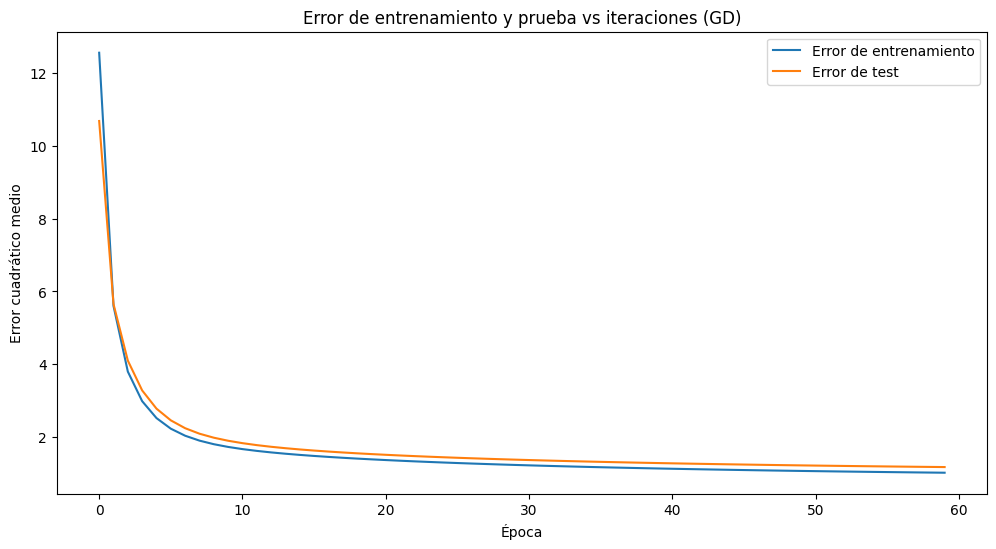

array([[ 0.53186852],
       [-0.37747063],
       [-0.00317667],
       [-0.03510658],
       [-0.05364755],
       [ 0.06972714],
       [ 0.13115214],
       [ 0.99071766],
       [-0.24318431],
       [ 0.51210658],
       [-0.6400968 ],
       [ 0.23008812],
       [-0.25897622],
       [-0.93534523],
       [ 0.20833729],
       [ 0.68367436],
       [-0.56940317],
       [ 0.00877523],
       [ 0.14173737],
       [ 0.58559154],
       [ 0.47982639],
       [-0.06648243],
       [ 0.08732953],
       [-0.03666788],
       [-0.39026602],
       [-1.19343748],
       [-1.10028582]])

In [1759]:
gradient_descent2(X_train, y_train_gd, X_test, y_test_gd, lr=0.1, epochs=60)

### Gradiente Descendiente Estocastico

In [1760]:
def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100):

    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W

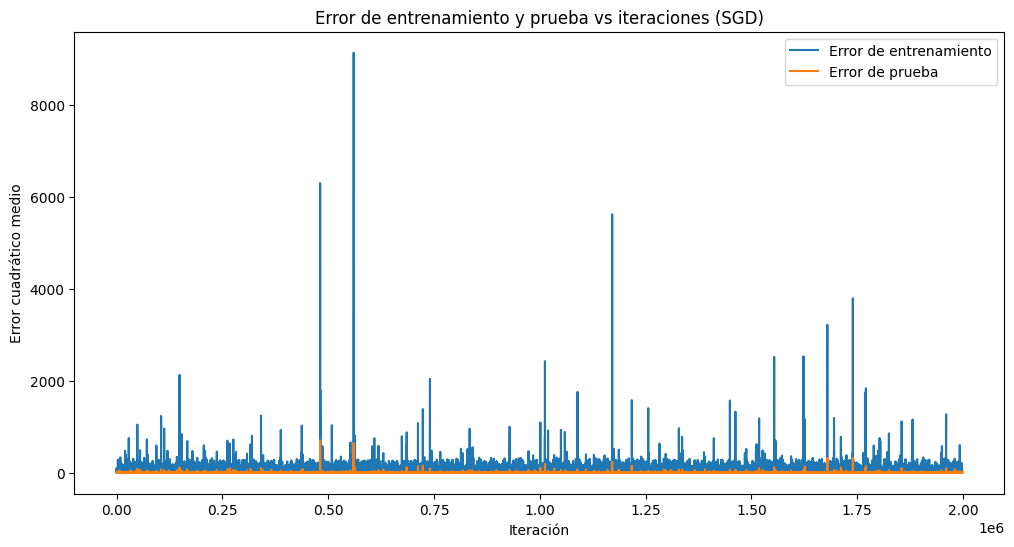

array([[ 0.08363343],
       [-0.05603519],
       [ 0.03755611],
       [-0.17894147],
       [ 0.08753976],
       [ 0.36091807],
       [-0.03787195],
       [-0.01611234],
       [ 0.05749407],
       [-0.53067701],
       [ 0.46313765],
       [ 0.12940592],
       [-0.06636645],
       [-0.05581012],
       [-0.06041884],
       [-0.24523226],
       [ 0.35966718],
       [-0.11591419],
       [-0.22361382],
       [ 0.27328434],
       [-0.0621294 ],
       [-0.074828  ],
       [-0.14947726],
       [-0.18980974],
       [ 0.04774676],
       [-0.10256085],
       [ 0.14874206]])

In [1761]:
stochastic_gradient_descent(X_train, y_train_gd, X_test, y_test_gd, lr=0.01, epochs=100)

### Gradiente Descendiente Estocastico Minibatch

In [1762]:
def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=11):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):

        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W

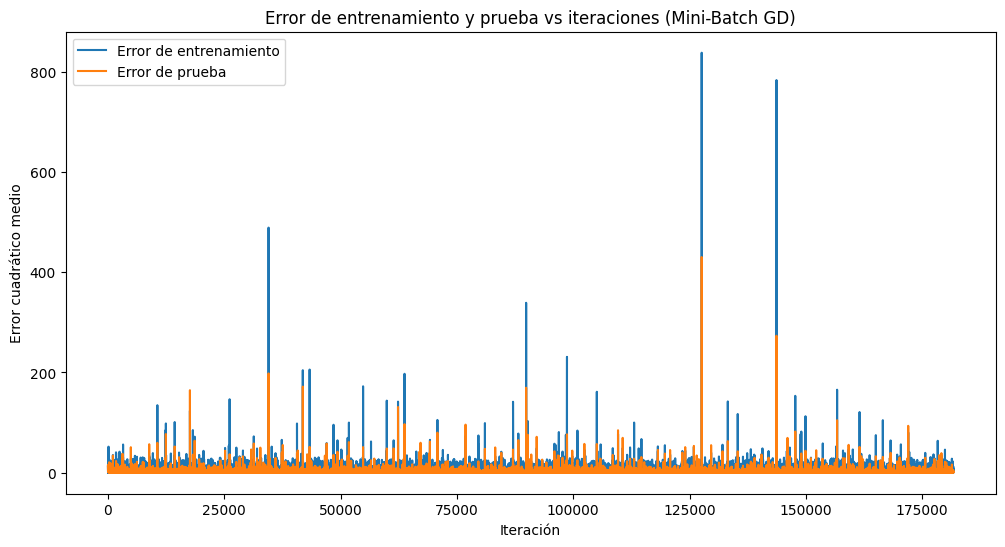

array([[ 0.14353562],
       [-0.05996571],
       [-0.02675418],
       [-0.13854866],
       [-0.03692389],
       [ 0.44408555],
       [-0.08840639],
       [ 0.2501148 ],
       [-0.04706707],
       [-0.26958919],
       [ 0.55492326],
       [ 0.62822805],
       [-0.41545234],
       [ 0.18645084],
       [ 0.04206293],
       [ 0.6221779 ],
       [-0.38484851],
       [-0.01638023],
       [-0.21755175],
       [ 0.01886103],
       [ 0.21046325],
       [ 0.00882761],
       [-0.10602289],
       [-0.09756298],
       [-0.13400879],
       [ 0.16281386],
       [ 0.09475333]])

In [1763]:
mini_batch_gradient_descent(X_train, y_train_gd, X_test, y_test_gd, lr=0.1, epochs=100, batch_size=11)

### Regularizacion

In [1764]:
y_train_reshape = y_train.values.reshape(-1, 1)

#### Ridge

In [1765]:
ridge = Ridge(alpha=0.1)

ridge.fit(X_train, y_train)

y_pred_train_ridge = lasso.predict(X_train)
y_pred_test_ridge = lasso.predict(X_test)

In [1766]:
# Puntaje R^2 del modelo
print("Ridge Score df_train:", ridge.score(X_train, y_train_reshape))
print("Ridge Score df_test:", ridge.score(X_test, y_test))

# Error de entrenamiento y prueba del modelo
mse_ridge_train = mean_squared_error(y_train_reshape, y_pred_train_ridge)
mse_ridge_test = mean_squared_error(y_test, y_pred_test_ridge)

# Imprimir los MSE
print("MSE ridge Train: ", mse_ridge_train.round(4))
print("MSE ridge Test: ", mse_ridge_test.round(4))

Ridge Score df_train: 0.21625684963876302
Ridge Score df_test: 0.22085125241795567
MSE ridge Train:  0.8415
MSE ridge Test:  1.0286


#### Lasso

In [1767]:
lasso = Lasso(alpha=0.1)

lasso.fit(X_train, y_train_reshape)

y_pred_train_lasso = lasso.predict(X_train)
y_pred_test_lasso = lasso.predict(X_test)

In [1768]:
# Puntaje R^2 del modelo
print("Lasso Score df_train:", lasso.score(X_train, y_train_reshape))
print("Lasso Score df_test:", lasso.score(X_test, y_test))

# Error de entrenamiento y prueba del modelo
mse_lasso_train = mean_squared_error(y_train_reshape, y_pred_train_lasso)
mse_lasso_test = mean_squared_error(y_test, y_pred_test_lasso)

# Imprimir los MSE
print("MSE Lasso Train: ", mse_lasso_train.round(4))
print("MSE Lasso Test: ", mse_lasso_test.round(4))

Lasso Score df_train: 0.15848853784472272
Lasso Score df_test: 0.1405237139120301
MSE Lasso Train:  0.8415
MSE Lasso Test:  1.0286


#### Elasticnet

In [1769]:
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)

elasticnet.fit(X_train,y_train)

y_pred_train_en = elasticnet.predict(X_train)
y_pred_test_en = elasticnet.predict(X_test)

In [1770]:
# Puntaje R^2 del modelo
print("Elasticnet Score df_train:", lasso.score(X_train, y_train_reshape))
print("Elasticnet Score df_test:", lasso.score(X_test, y_test))

# Error de entrenamiento y prueba del modelo
mse_en_train = mean_squared_error(y_train_reshape, y_pred_train_en)
mse_en_test = mean_squared_error(y_test, y_pred_test_en)

# Imprimir los MSE
print("MSE Lasso Train: ", mse_en_train.round(4))
print("MSE Lasso Test: ", mse_en_test.round(4))

Elasticnet Score df_train: 0.15848853784472272
Elasticnet Score df_test: 0.1405237139120301
MSE Lasso Train:  0.8185
MSE Lasso Test:  0.9959


### Conclusiones

| Modelo | Conjunto | MSE | 
|---------|---------|---------|
| Regresion Lineal | Train | 0.7837 |
| Regresion Lineal | Test | 0.9325 |
| Gradiente Descendiente | Train | 0.8716 |
| Gradiente Descendiente | Test | 1.0220 |
| Ridge | Train | 0.8415 |
| Ridge | Test | 1.0286 |
| Lasso | Train | 0.8415 |
| Lasso | Test | 1.0286 |
| Elasticnet | Train | 0.8185 |
| Elasticnet | Test | 0.9959 |

El modelo de **Regresión Lineal** simple es el que mejor equilibra el desempeño entre Train y test, con un MSE más bajo que los modelos regularizados y el gradiente descendiente. 
A pesar de que los modelos con regularización están diseñados para mejorar la generalización y evitar el sobreajuste, en este caso no han logrado un rendimiento superior, e incluso han mostrado un ligero empeoramiento en el conjunto de prueba.

El gradiente descendiente tampoco superó a la regresión lineal, lo que sugiere que podrían ser necesarios ajustes adicionales.

# Regresion Logistica

### Split de datos

In [1771]:
X_train_rl = df_train_escalado.drop(columns=['Date', 'RainTomorrow', 'RainfallTomorrow'])
y_train_rl = df_train_escalado['RainTomorrow']

X_test_rl = df_test_escalado.drop(columns=['Date', 'RainTomorrow', 'RainfallTomorrow'])
y_test_rl = df_test_escalado['RainTomorrow']

### Modelo

In [1772]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train_rl, y_train_rl)

y_pred_train_rl = logistic_model.predict(X_train_rl)
y_pred_test_rl = logistic_model.predict(X_test_rl)

Resultados con regresión logística en el conjunto de entrenamiento

              precision    recall  f1-score   support

           0       0.86      0.94      0.90     15242
           1       0.73      0.53      0.61      4739

    accuracy                           0.84     19981
   macro avg       0.80      0.73      0.76     19981
weighted avg       0.83      0.84      0.83     19981

accuracy balanceado: 0.7339054836179026
Perdida logarítmica: 5.693096946902244
F1-Score: 0.571262361838278
------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------
Resultados con regresión logística en el conjunto de test

              precision    recall  f1-score   support

           0       0.85      0.95      0.89      3271
           1    

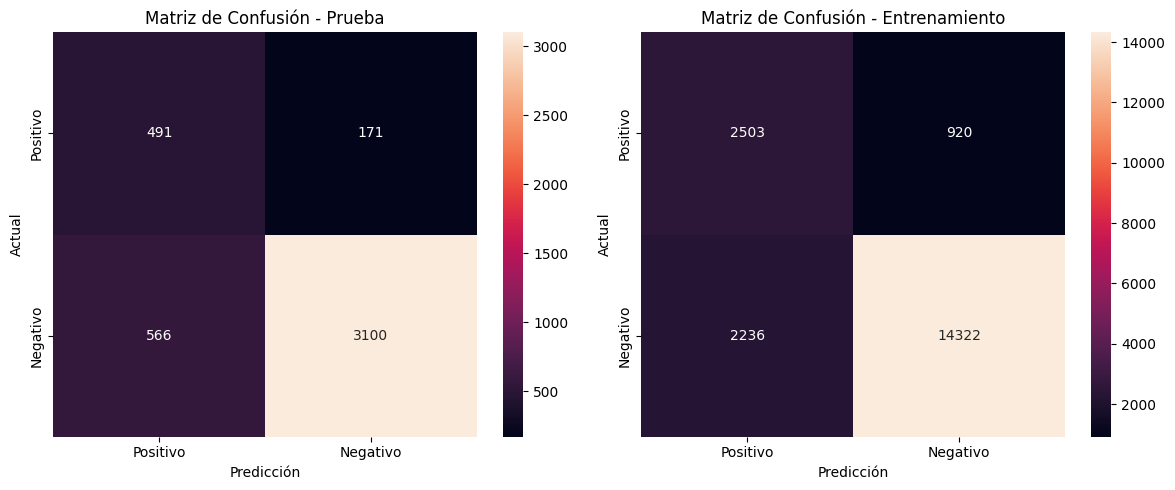

In [1773]:
print("Resultados con regresión logística en el conjunto de entrenamiento\n")
print(classification_report(y_train_rl, y_pred_train_rl))
balanced_accuracy_train = balanced_accuracy_score(y_train_rl, y_pred_train_rl)
print("accuracy balanceado:", balanced_accuracy_train)
loss_train = log_loss(y_train_rl, y_pred_train_rl)
print("Perdida logarítmica:", loss_train)
f1_train = f1_score(y_test_rl, y_pred_test_rl)
print("F1-Score:", f1_train)
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Resultados con regresión logística en el conjunto de test\n")
print(classification_report(y_test_rl, y_pred_test_rl))
balanced_accuracy_test = balanced_accuracy_score(y_test_rl, y_pred_test_rl)
print("accuracy balanceado:", balanced_accuracy_test)
loss_test = log_loss(y_test_rl, y_pred_test_rl)
print("Perdida logarítmica:", loss_test)
f1_test = f1_score(y_test_rl, y_pred_test_rl)
print("F1-Score:", f1_test)

print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")

# conf_matrix_train = confusion_matrix(y_train_rl, y_pred_train_rl)
# Matriz de confusion TRAIN
tnT, fpT, fnT, tpT = confusion_matrix(y_train_rl, y_pred_train_rl).ravel()
confusion_mat_train = [[tpT, fpT],[fnT, tnT]]
df_cm_train = pd.DataFrame(confusion_mat_train, index=['Positivo', 'Negativo'],
                     columns=['Positivo', 'Negativo'])
# Matriz de confusion TEST
tn, fp, fn, tp = confusion_matrix(y_test_rl, y_pred_test_rl).ravel()
confusion_mat_test = [[tp, fp],[fn, tn]]
df_cm_test = pd.DataFrame(confusion_mat_test, index=['Positivo', 'Negativo'],
                     columns=['Positivo', 'Negativo'])
# conf_matrix_test = confusion_matrix(y_test_rl, y_pred_test_rl)


# Configurar el tamaño de la figura
plt.figure(figsize=(12, 5))

# Matriz de confusión para el conjunto de prueba
plt.subplot(1, 2, 1)
# sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
sns.heatmap(df_cm_test, annot=True, fmt='d')
plt.title('Matriz de Confusión - Prueba')
plt.xlabel('Predicción')
plt.ylabel('Actual')

# Matriz de confusión para el conjunto de entrenamiento
plt.subplot(1, 2, 2)
# sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues')
sns.heatmap(df_cm_train, annot=True, fmt='d')
plt.title('Matriz de Confusión - Entrenamiento')
plt.xlabel('Predicción')
plt.ylabel('Actual')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Curva ROC

In [1774]:
# Obtengo las probabilidades de predicción del modelo para los datos de entrenamiento y prueba
y_probs_train = logistic_model.predict_proba(X_train_rl)[:, 1]
y_probs_test = logistic_model.predict_proba(X_test_rl)[:, 1]

# Calculo la ROC y el AUC para los datos de entrenamiento y prueba
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_rl, y_probs_train, pos_label= 1)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test_rl, y_probs_test, pos_label= 1)
roc_auc_test = auc(fpr_test, tpr_test)

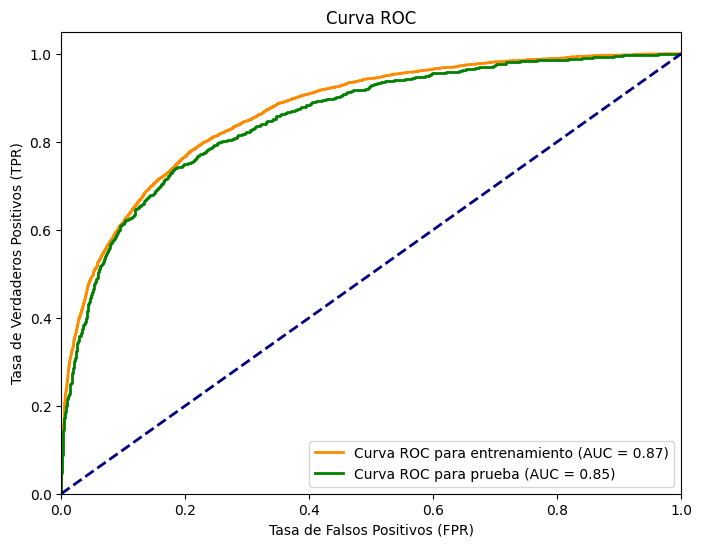

El área bajo la curva para entrenamiento es de: 0.868398572385767
El área bajo la curva para test es de: 0.8536631219509655


In [1775]:
# Grafico la curva ROC para los datos de entrenamiento y prueba
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Curva ROC para entrenamiento (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='Curva ROC para prueba (AUC = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

print(f"El área bajo la curva para entrenamiento es de: {roc_auc_train}")
print(f"El área bajo la curva para test es de: {roc_auc_test}")

### Observaciones y Conclusion

La primera observacion es que los valores obtenidos para cada metrica en el conjunto de **Train** como de **Test** son muy similares.

* **Precisión:** Tanto en Train como en Test, la clase 0 tiene un valor mas alto comparación con la clase 1, lo que sugiere que el modelo es mejor identificando las instancias negativas que las positivas.
* **Recall:** De igual forma, en Train y Test, el valor de recall para la clase 0 es significativamente superior que el de la clase 1. El modelo es capaz de capturar efectivamente la mayoria de los casos que son verdaderos negativos, pero falla bastante al capturar los casos verdaderos positivos.
* **F1-Score:** La clase 0 tiene un F1-Score alto, el modelo es fuerte en la predicción de la clase negativa y el F1-Score para la clase 1 es significativamente menor, el modelo tiene dificultades para predecir correctamente esta clase.
---
En cuanto a la metrica de mi interes, ya que es la que voy a usar para comparar el desempeño de mis modelos de clasificacion.
* **F1-Score general** puedo decir que el modelo tiene un desempeño moderado cuando se consideran ambas clases de manera agregada, pero claramente tiene dificultades con la clase positiva.

# Modelos Base, Validacion Cruzada K-Folds y Optimizacion de Hiperparametros

### Modelo Base de Regresion

In [1776]:
X_train_rlb = X_train[["Rainfall", "RainToday"]]
X_test_rlb = X_test[["Rainfall", "RainToday"]]

model_rlb = LinearRegression()

model_rlb.fit(X_train_rlb, y_train)

y_pred = model_rlb.predict(X_test_rlb)

coefficients = model_rlb.coef_
intercept = model_rlb.intercept_
print("Coefficients:", coefficients)
print("Intercept:", intercept)

# MSE: Error Cuadratico Medio
mse = mean_squared_error(y_test, y_pred)
# R^2
r2 = r2_score(y_test, y_pred)
# MAE: Error Absoluto Medio
mae = mean_absolute_error(y_test, y_pred)
# RMSE: Raíz del Error Cuadrático Medio
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nR^2: {r2}\n")
print(f"MSE(Error Cuadratico Medio): {mse}\n")
print(f"MAE(Error Absoluto Medio): {mae}\n")
print(f"RMSE(Raíz del Error Cuadrático Medio): {rmse}\n")

Coefficients: [0.20412472 0.23366872]
Intercept: -0.055069615623230234

R^2: 0.08825875829234675

MSE(Error Cuadratico Medio): 1.0911915379631145

MAE(Error Absoluto Medio): 0.47343011744998376

RMSE(Raíz del Error Cuadrático Medio): 1.0446011382164555



Con un **R²** es de 0.084 observamos que el modelo no tiene una gran capacidad para explicar la variabilidad de los datos.

El **MSE** resulta elevado tambien.

Las metricas obtenidas nos sugieren que las predicciones del modelo no son precisas y tienen un error significativo, seguramente producto de ser un modelo demasiado simple.

#### Validacion Cruzada K-Folds

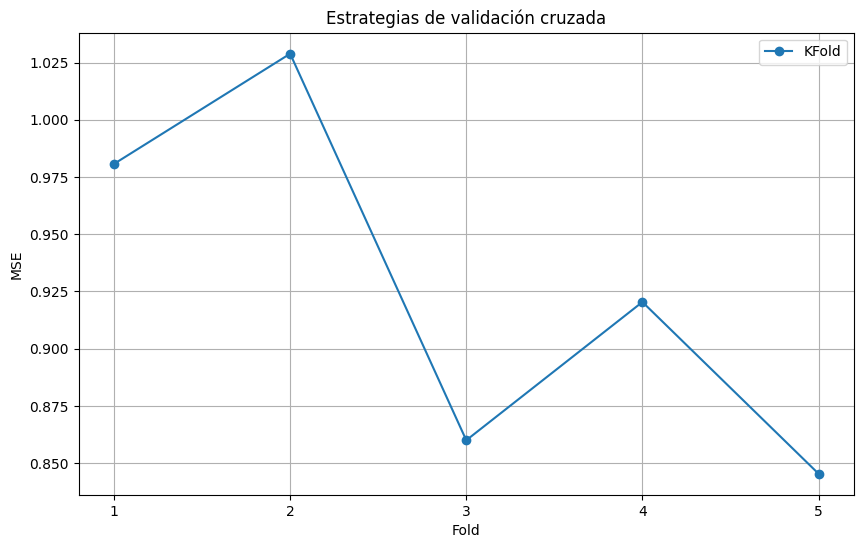

In [1777]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Aplicar KFold Cross-Validation y calcular MSE
mse_scores_kf = -cross_val_score(model_rlb, X_train_rlb, y_train, scoring='neg_mean_squared_error', cv=kf)

labels = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
x = np.arange(len(labels))

plt.figure(figsize=(10, 6))

plt.plot(x + 1, mse_scores_kf, 'o-', label='KFold')

plt.xlabel('Fold')
plt.ylabel('MSE')
plt.title('Estrategias de validación cruzada')
plt.xticks(x + 1)
plt.legend()
plt.grid(True)

plt.show()

#### Optimizacion de Hiperparametros con GridSearch

### Modelo Base de Clasificacion

In [1778]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

In [1779]:
X_train_rl_base = X_train_rl[['RainToday', 'Sunshine']]
X_test_rl_base = X_test_rl[['RainToday', 'Sunshine']]
y_train_rl
y_test_rl

logistic_model_base = LogisticRegression(random_state=42)
logistic_model_base.fit(X_train_rl_base, y_train_rl)

y_pred_train_rl_base = logistic_model_base.predict(X_train_rl_base)
y_pred_test_rl_base = logistic_model_base.predict(X_test_rl_base)

In [1780]:
print("Resultados con regresión logística en el conjunto de entrenamiento\n")
print(classification_report(y_train_rl, y_pred_train_rl_base))
balanced_accuracy_train = balanced_accuracy_score(y_train_rl, y_pred_train_rl_base)
print("accuracy balanceado:", balanced_accuracy_train)
loss_train = log_loss(y_train_rl, y_pred_train_rl_base)
print("Perdida logarítmica:", loss_train)
f1_train = f1_score(y_train_rl, y_pred_train_rl_base)
print("F1-Score:", f1_train)
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Resultados con regresión logística en el conjunto de test\n")
print(classification_report(y_test_rl, y_pred_test_rl_base))
balanced_accuracy_test = balanced_accuracy_score(y_test_rl, y_pred_test_rl_base)
print("accuracy balanceado:", balanced_accuracy_test)
loss_test = log_loss(y_test_rl, y_pred_test_rl_base)
print("Perdida logarítmica:", loss_test)
f1_test = f1_score(y_test_rl, y_pred_test_rl_base)
print("F1-Score:", f1_test)


Resultados con regresión logística en el conjunto de entrenamiento

              precision    recall  f1-score   support

           0       0.82      0.94      0.87     15242
           1       0.62      0.32      0.42      4739

    accuracy                           0.79     19981
   macro avg       0.72      0.63      0.65     19981
weighted avg       0.77      0.79      0.77     19981

accuracy balanceado: 0.6299318591339182
Perdida logarítmica: 7.500601110652576
F1-Score: 0.42314095449500555
------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------
Resultados con regresión logística en el conjunto de test

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      3271
           1  

c:\Users\Francisco\Desktop\AA1-TUIA-RodriguezYBarros\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Francisco\Desktop\AA1-TUIA-RodriguezYBarros\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Francisco\Desktop\AA1-TUIA-RodriguezYBarros\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

#### Validacion Cruzada K-Folds

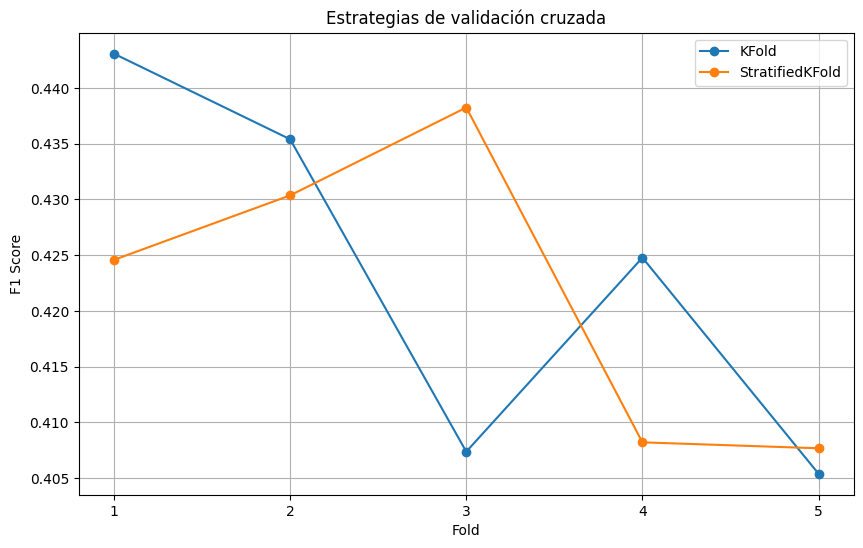

In [1781]:
# Configurar KFold y StratifiedKFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calcular F1-Score con KFold Cross-Validation
f1_scores_kf = cross_val_score(logistic_model_base, X_train_rl_base, y_train_rl, scoring='f1', cv=kf)

# Calcular F1-Score con StratifiedKFold Cross-Validation
f1_scores_skf = cross_val_score(logistic_model_base, X_train_rl_base, y_train_rl, scoring='f1', cv=skf)

# Graficar comparación de F1-Score entre KFold y StratifiedKFold
labels = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
x = np.arange(len(labels))  # Posiciones en X

plt.figure(figsize=(10, 6))

plt.plot(x + 1, f1_scores_kf, 'o-', label='KFold')
plt.plot(x + 1, f1_scores_skf, 'o-', label='StratifiedKFold')

plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('Estrategias de validación cruzada')
plt.xticks(x + 1)
plt.legend()
plt.grid(True)

plt.show()

#### Grdi Search

In [1782]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

# Implementar GridSearchCV
grid_search = GridSearchCV(estimator=logistic_model_base, param_grid=param_grid, scoring='f1', cv=5)

# Ajustar el modelo con la búsqueda en la cuadrícula de hiperparámetros
grid_search.fit(X_train_rl_base, y_train_rl)

# Obtener los mejores parámetros y la puntuación correspondiente
best_params = grid_search.best_params_
best_f1 = grid_search.best_score_

best_params, best_f1

c:\Users\Francisco\Desktop\AA1-TUIA-RodriguezYBarros\env\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
525 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Francisco\Desktop\AA1-TUIA-RodriguezYBarros\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Francisco\Desktop\AA1-TUIA-RodriguezYBarros\env\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Fran

({'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'},
 0.4214279586150713)

In [1783]:
logistic_model_base_opt = LogisticRegression(
    random_state=42,
    C=0.01,
    max_iter=100,
    penalty='l2',
    solver='liblinear'
)

logistic_model_base_opt.fit(X_train_rl_base, y_train_rl)

y_pred_train_rl_base_opt = logistic_model_base_opt.predict(X_train_rl_base)
y_pred_test_rl_base_opt = logistic_model_base_opt.predict(X_test_rl_base)


In [1784]:
print("Resultados con regresión logística en el conjunto de entrenamiento\n")
print(classification_report(y_train_rl, y_pred_train_rl_base_opt))
balanced_accuracy_train = balanced_accuracy_score(y_train_rl, y_pred_train_rl_base_opt)
print("accuracy balanceado:", balanced_accuracy_train)
loss_train = log_loss(y_train_rl, y_pred_train_rl_base_opt)
print("Perdida logarítmica:", loss_train)
f1_train = f1_score(y_train_rl, y_pred_train_rl_base_opt)
print("F1-Score:", f1_train)
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Resultados con regresión logística en el conjunto de test\n")
print(classification_report(y_test_rl, y_pred_test_rl_base_opt))
balanced_accuracy_test = balanced_accuracy_score(y_test_rl, y_pred_test_rl_base_opt)
print("accuracy balanceado:", balanced_accuracy_test)
loss_test = log_loss(y_test_rl, y_pred_test_rl_base_opt)
print("Perdida logarítmica:", loss_test)
f1_test = f1_score(y_test_rl, y_pred_test_rl_base_opt)
print("F1-Score:", f1_test)

Resultados con regresión logística en el conjunto de entrenamiento

              precision    recall  f1-score   support

           0       0.82      0.94      0.87     15242
           1       0.61      0.32      0.42      4739

    accuracy                           0.79     19981
   macro avg       0.71      0.63      0.65     19981
weighted avg       0.77      0.79      0.76     19981

accuracy balanceado: 0.6281878982506302
Perdida logarítmica: 7.556521898153833
F1-Score: 0.41972572378445766
------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------
Resultados con regresión logística en el conjunto de test

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      3271
           1  

c:\Users\Francisco\Desktop\AA1-TUIA-RodriguezYBarros\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Francisco\Desktop\AA1-TUIA-RodriguezYBarros\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Francisco\Desktop\AA1-TUIA-RodriguezYBarros\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

# SHAP

### Regresion Lineal

##### Explicabilidad Local

In [1785]:
# Crea un objeto explainer SHAP
feature_names = X_train.columns.values
feature_names
explainer = shap.LinearExplainer(rl_model_opt, X_train, feature_names=feature_names)
shap_values = explainer.shap_values(X_test)
shap_values.shape

(4328, 26)

In [1786]:
explainer.expected_value

0.011438331730556084

In [1787]:
index=0
rl_model_opt.predict(X_test)[index]

-0.4151833906388151

In [1788]:
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)

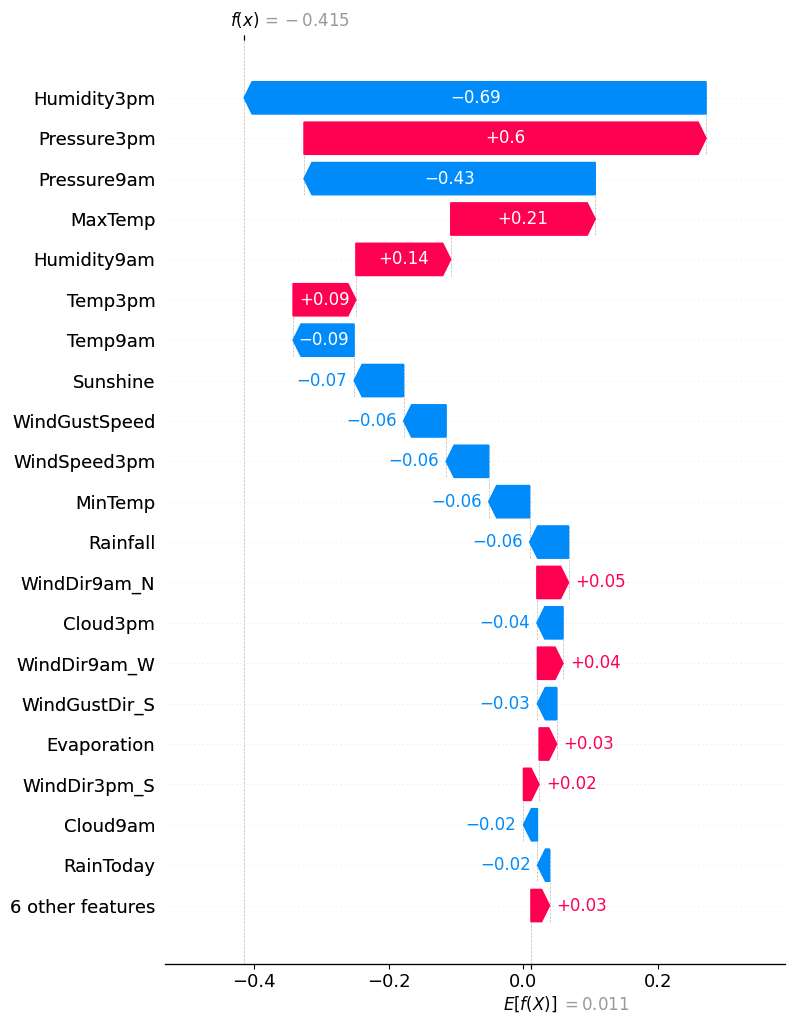

In [1789]:
shap.plots.waterfall(explanation, max_display=21)

Las variables con mayor peso al predecir el valor de RainfallTomorrow (cantidad de lluvia mañana) son Humidity3pm, Pressure3pm y Pressure9am.

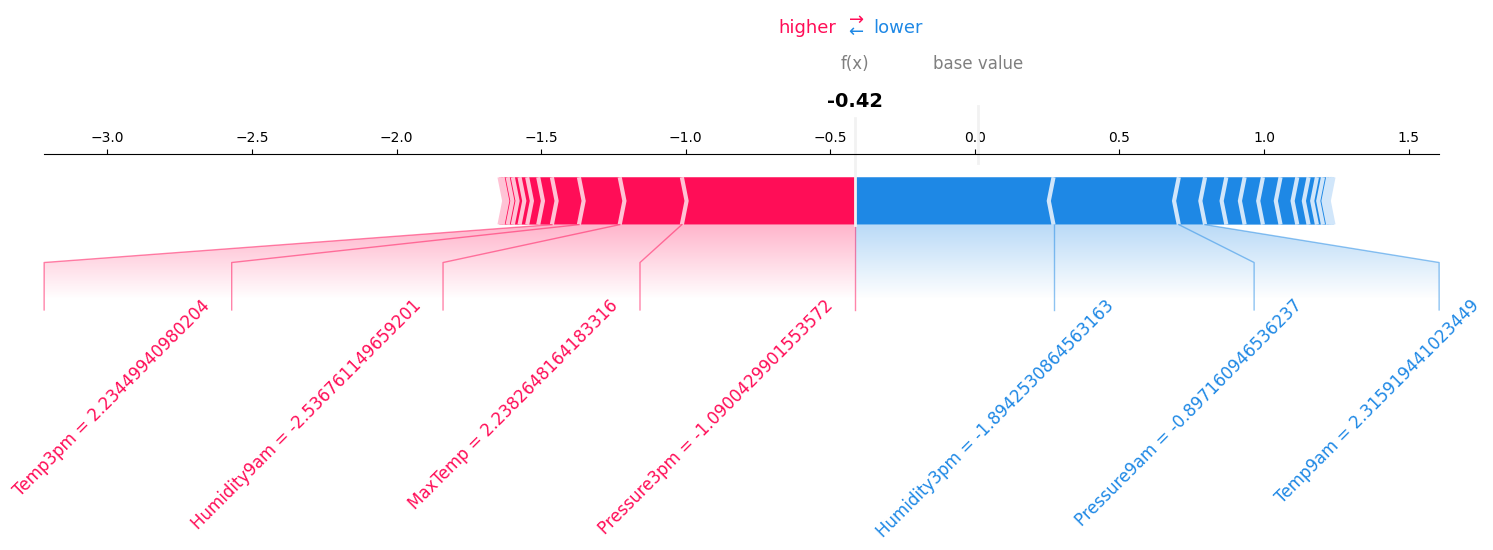

In [1790]:
shap.force_plot(explainer.expected_value, shap_values[index], X_test.iloc[index], feature_names=feature_names, matplotlib=True, figsize=(18, 4), text_rotation=45)

##### Explicabilidad Global

In [1791]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test)

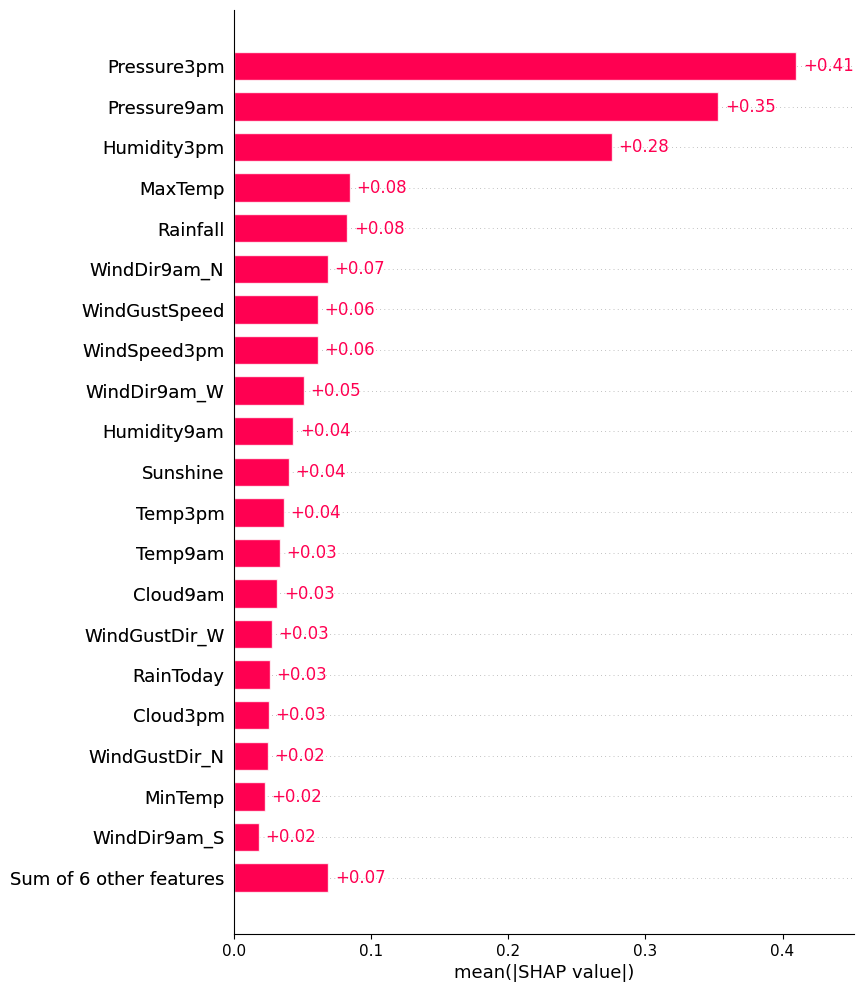

In [1792]:
shap.plots.bar(explanation, max_display=21)

De forma global, observo que las variables con mas peso siguien siendo Pressure3pm, Pressure9am y Humidity3pm.

### Regresion Logistica

##### Explicabilidad Local

In [1793]:
# Crea un objeto explainer SHAP
feature_names=X_train_rl.columns.values
feature_names
explainer = shap.LinearExplainer(logistic_model, X_test_rl, feature_names=feature_names)

# Calcula los valores SHAP para un conjunto de ejemplos de prueba
shap_values = explainer.shap_values(X_test_rl)

shap_values.shape

(4328, 26)

In [1794]:
index=0
logistic_model.predict_proba(X_test_rl)[index]
logistic_model.predict(X_test_rl)[index]

0

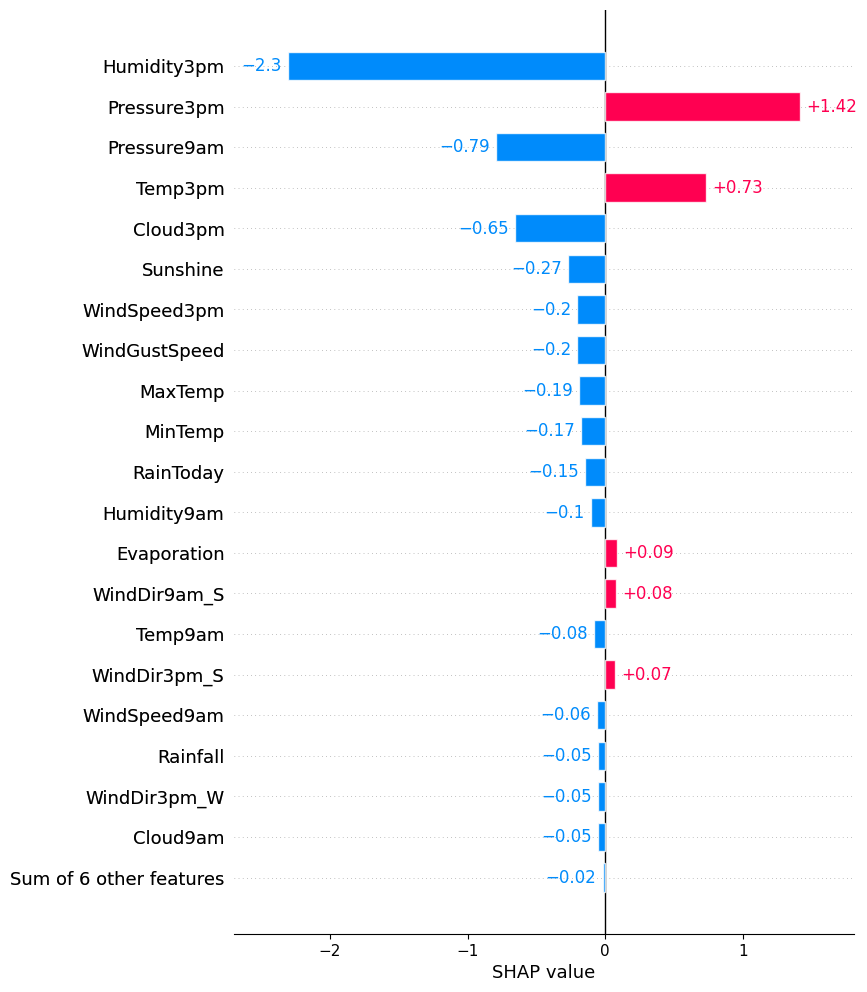

In [1795]:
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)
shap.plots.bar(explanation, max_display=21)

De forma local, las variables con mas peso a la hora de predecir el valor de RainTomorrow son Humidity3pm, Pressure3pm, Pressure9am y Temp3pm.

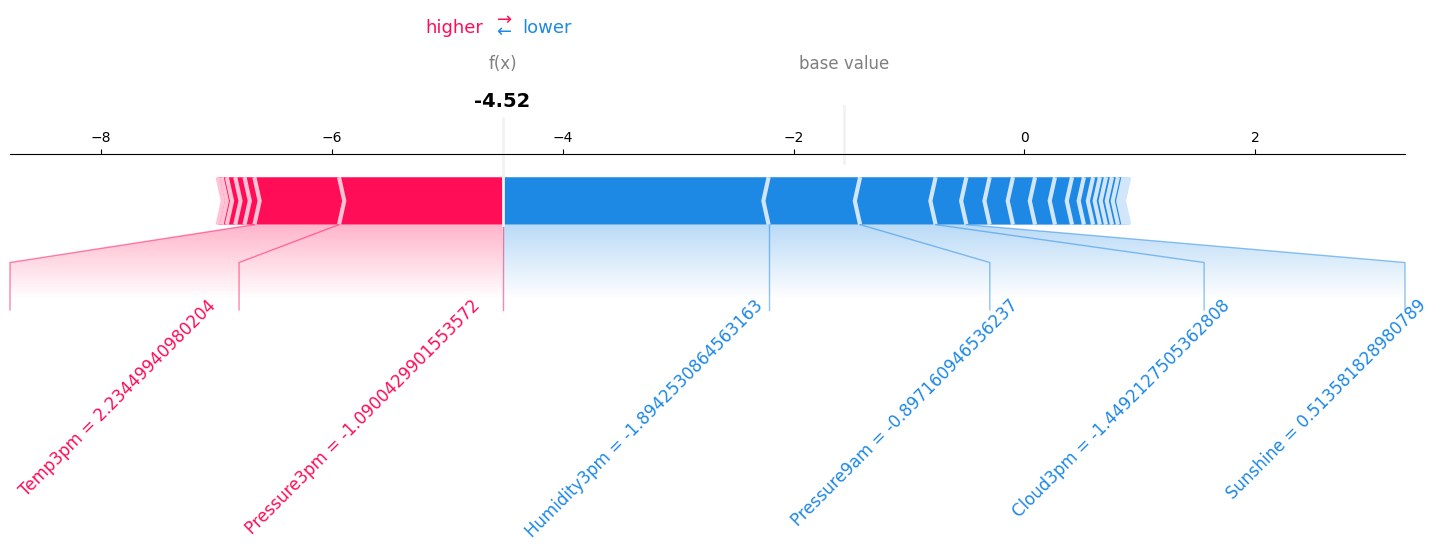

In [1796]:
shap.force_plot(explainer.expected_value, shap_values[index], X_test_rl.iloc[index], feature_names=feature_names, matplotlib=True, figsize=(18, 4), text_rotation=45)


##### Explicabilidad Global

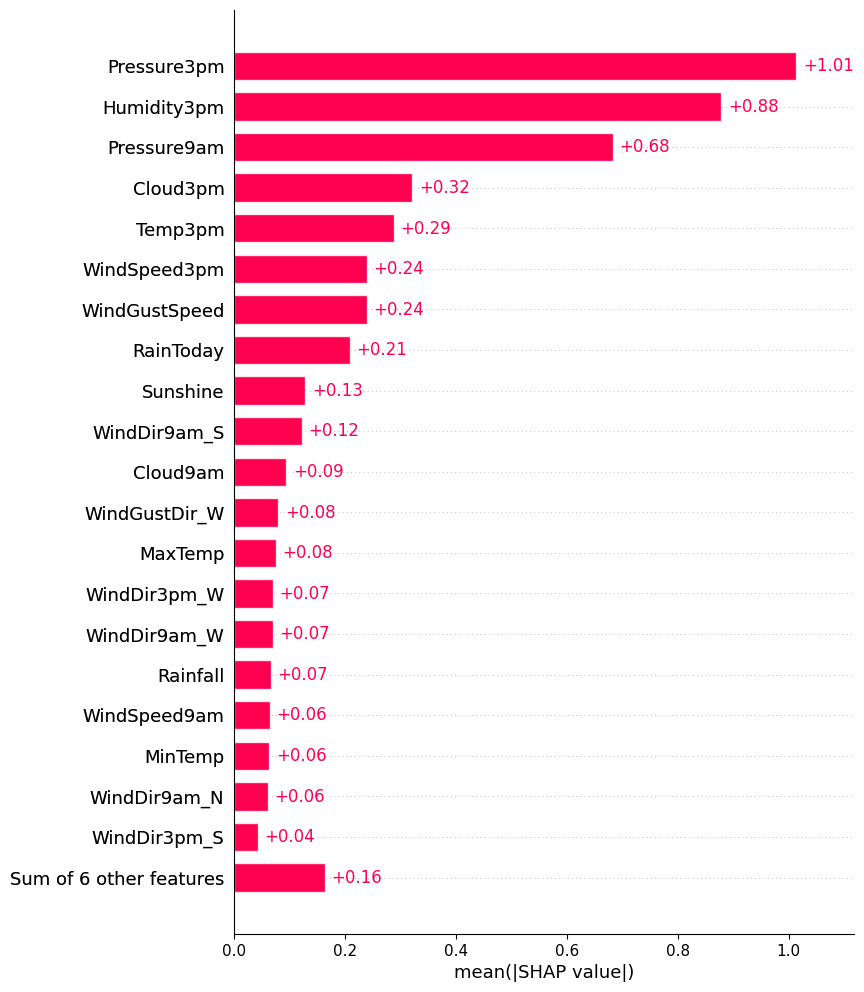

In [1797]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=feature_names, data=X_test_rl)
shap.plots.bar(explanation, max_display=21)

A nivel global las variables mas importantes son Pressure3pm, Humidity3pm y pressure9am.

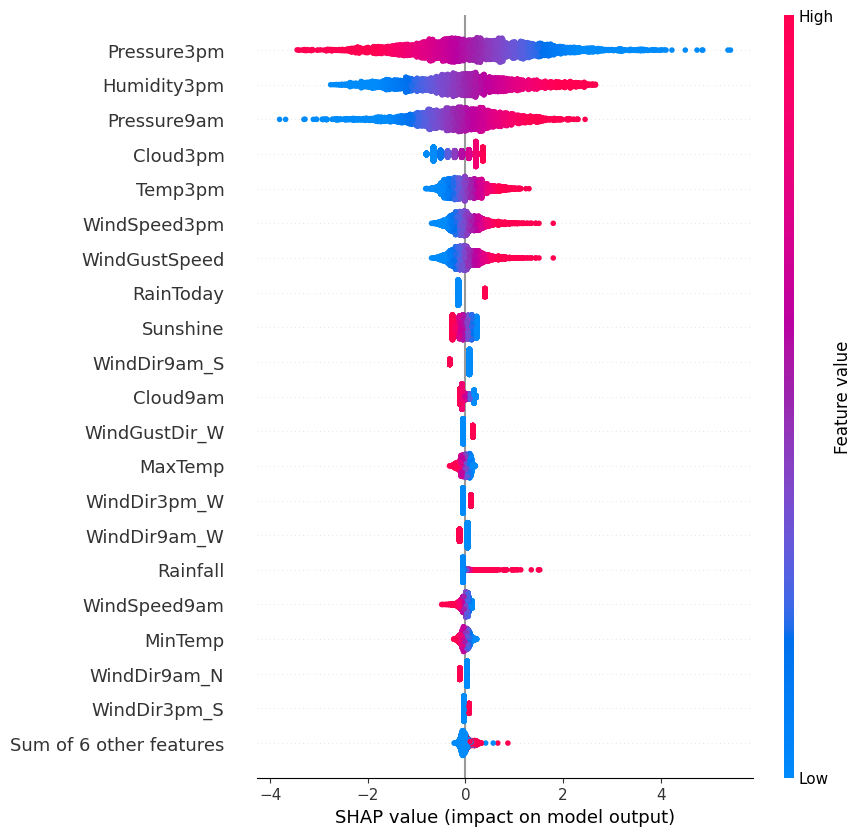

In [1798]:
shap.plots.beeswarm(explanation, max_display=21)

Segun el grafico de abejas, cuanta mas presion haya a las 3pm del dia anterior, mas impacto tiene esta variable al predecir al predecir la lluvia del dia siguiente.

# Redes Neuronales

### RainfallTomorrow

In [1799]:
class NeuralNetworkTensorFlow:
    """
        Este es un modelo simple con TensorFlow para resolver el mismo problema. 
        En esta clase, (1) se construye el modelo.
        (2) Se define como se fitea el modelo
        (3) Y como se hacen las predicciones.
    """
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        """
            Construye el modelo
            Para construir el modelo es necesario una arquitectura, un optimizador y una función de pérdida.
            La arquitectura se construye con el método Sequential, que basicamente lo que hace es colocar 
            secuencialmente las capas que uno desea.
            Las capas "Dense" son las fully connected dadas en clase.
            Se agrega una capa oculta que recibe un input de tamaño 2,
            y una capa de salida de regresión (una única neurona)
            En todos los casos se define una sigmoidea como función de activación (prueben otras!)

            El optimizador y la función de pérdida se especifican dentro de un compilador.

            Con este método, lo que se devuelve es el modelo sin entrenar, sería equivalente a escribir LinearRegression() 
            en el caso de la regresión lineal.
        """

        model = tf.keras.Sequential([
            tf.keras.layers.Dense(2, activation='sigmoid', input_shape=(26,)),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        ### imprimimos la cantidad de parámetros a modo de ejemplo
        print("n° de parámetros:", model.count_params())
        return model
    
        # #input_shape=(self.valor1,self.valor2)
        # model = tf.keras.Sequential()
        # model.add(Input(shape=(21,)))
        # model.add(Dense(2, activation='sigmoid'))
        # model.add(Dense(1, activation='sigmoid'))
        # model.compile(optimizer='adam', loss='mean_squared_error')
        # ### imprimimos la cantidad de parámetros a modo de ejemplo
        # print("n° de parámetros:", model.count_params())
        # return model
    
    def fit(self, X, y, lr=0.1, epochs=200):
        ### esta es la función donde se entrena el modelo, fijarse que hay un learning rate e iteraciones.
        ### la función que fitea devuelve una historia de pérdida, que vamos a guardar para graficar la evolución.
        X = np.array(X)
        y = np.array(y)
        history = self.model.fit(X, y, epochs=epochs, verbose=0)
        return history.history['loss']

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions

In [1800]:
# Crear y entrenar el modelo
nn_model = NeuralNetworkTensorFlow()
train_loss_history = nn_model.fit(X_train, y_train, epochs=100)

# Realizar predicciones en ambos conjuntos
y_pred_train = nn_model.predict(X_train)
y_pred_test = nn_model.predict(X_test)

c:\Users\Francisco\Desktop\AA1-TUIA-RodriguezYBarros\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


n° de parámetros: 57
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step


In [1801]:
# Calcular el MSE para entrenamiento y prueba
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

# Imprimir los resultados
print(f"MSE en el conjunto de entrenamiento: {mse_train}")
print(f"MSE en el conjunto de prueba: {mse_test}")

MSE en el conjunto de entrenamiento: 0.8188789037331785
MSE en el conjunto de prueba: 1.0084017984713558


##### Optimizacion de Hiperparametros con Optuna

In [1802]:
def objective(trial):
    num_layers = trial.suggest_int('num_layers', 1, 3)
    model = Sequential()

    # Crear las capas ocultas
    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 1, 32)
        model.add(Dense(num_units, activation='relu'))

    # Capa de salida para regresión
    model.add(Dense(1, activation='linear'))

    # Compilar el modelo
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

    # Sugerir el número de epochs como hiperparámetro
    epochs = trial.suggest_int('epochs', 5, 50)

    # Entrenar el modelo
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32, verbose=0)

    # Evaluar el modelo y obtener el MSE
    mse = model.evaluate(X_test, y_test, verbose=0)[0]
    
    # Devuelve el MSE como métrica para minimizar
    return mse

In [1803]:
# Crear un estudio de Optuna para minimizar el MSE
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores parámetros encontrados:", best_params)

[I 2024-08-04 15:03:34,554] A new study created in memory with name: no-name-392d624b-eed4-4a8e-a23e-1e29eb3961d7
[I 2024-08-04 15:04:03,718] Trial 0 finished with value: 0.8880308866500854 and parameters: {'num_layers': 2, 'n_units_layer_0': 14, 'n_units_layer_1': 1, 'epochs': 40}. Best is trial 0 with value: 0.8880308866500854.
[I 2024-08-04 15:04:11,009] Trial 1 finished with value: 0.8403398990631104 and parameters: {'num_layers': 3, 'n_units_layer_0': 13, 'n_units_layer_1': 26, 'n_units_layer_2': 16, 'epochs': 10}. Best is trial 1 with value: 0.8403398990631104.
[I 2024-08-04 15:04:25,326] Trial 2 finished with value: 0.8223841786384583 and parameters: {'num_layers': 2, 'n_units_layer_0': 4, 'n_units_layer_1': 13, 'epochs': 25}. Best is trial 2 with value: 0.8223841786384583.
[I 2024-08-04 15:04:36,077] Trial 3 finished with value: 0.8616284132003784 and parameters: {'num_layers': 1, 'n_units_layer_0': 1, 'epochs': 21}. Best is trial 2 with value: 0.8223841786384583.
[I 2024-08-04

Mejores parámetros encontrados: {'num_layers': 1, 'n_units_layer_0': 30, 'epochs': 30}


Mejores parámetros encontrados: {'num_layers': 1, 'n_units_layer_0': 30, 'epochs': 34}

In [1804]:
# Definir el modelo con los mejores hiperparámetros
nn_model_opt = Sequential()

# Añadir la capa oculta con 30 unidades y activación 'relu'
nn_model_opt.add(Dense(30, activation='relu', input_shape=(X_train.shape[1],)))
# Añadir la capa de salida para regresión con activación 'linear'
nn_model_opt.add(Dense(1, activation='linear'))

nn_model_opt.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

nn_model_opt.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=34, batch_size=32, verbose=1)

mse_train = nn_model_opt.evaluate(X_train, y_train, verbose=0)[0]
mse_test = nn_model_opt.evaluate(X_test, y_test, verbose=0)[0]

# Mostrar los resultados
print(f"MSE en el conjunto de entrenamiento: {mse_train}")
print(f"MSE en el conjunto de prueba: {mse_test}")

Epoch 1/34


c:\Users\Francisco\Desktop\AA1-TUIA-RodriguezYBarros\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 801us/step - loss: 0.9318 - mse: 0.9318 - val_loss: 0.9213 - val_mse: 0.9213
Epoch 2/34
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 855us/step - loss: 0.7227 - mse: 0.7227 - val_loss: 0.8801 - val_mse: 0.8801
Epoch 3/34
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - loss: 0.6917 - mse: 0.6917 - val_loss: 0.8690 - val_mse: 0.8690
Epoch 4/34
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step - loss: 0.6751 - mse: 0.6751 - val_loss: 0.8504 - val_mse: 0.8504
Epoch 5/34
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step - loss: 0.7803 - mse: 0.7803 - val_loss: 0.8448 - val_mse: 0.8448
Epoch 6/34
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step - loss: 0.6803 - mse: 0.6803 - val_loss: 0.8373 - val_mse: 0.8373
Epoch 7/34
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 882us/step - loss: 0.6394 - mse: 0.6394 - val_loss: 0.8358 - val_mse: 0.8358
Epoch 8/34
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7056 - mse: 0.7056 - val_loss: 0.8288 - val_mse: 0.8288
Epoch 9/34
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step -

##### Explicabilidad Local

In [1805]:
import shap

In [1806]:
# Crea un objeto explainer SHAP
feature_names = X_train.columns.values
feature_names

# Crear un conjunto de muestras de fondo
background = X_train.sample(100) 

explainer = shap.KernelExplainer(nn_model_opt, background)

instance_to_explain = X_test.iloc[0:1].values  # Seleccionar la línea 0

# Calcular los valores SHAP para los datos de prueba
shap_values = explainer.shap_values(instance_to_explain)

100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


In [1807]:
shap_values = shap_values.reshape(26,)
shap_values

array([-0.03139982, -0.12807625, -0.00483464,  0.04906477, -0.3543891 ,
        0.00581231, -0.34880903, -0.05388931,  0.3176627 , -0.1889649 ,
        0.02034966, -0.05382489,  0.2998093 ,  0.07039896, -0.10115681,
        0.02006555,  0.01957351, -0.02565011,  0.03230623, -0.02897907,
        0.00996879, -0.00173263,  0.        , -0.02449167,  0.06156853,
       -0.03101701])

In [1808]:
# Obtener el valor esperado (base value)
expected_value = explainer.expected_value

# Hacer predicciones
index = 0  # índice de la instancia que queremos explicar
predicted_proba = nn_model_opt.predict(X_test)[index]  # Predicción de probabilidad
predicted_class = np.argmax(predicted_proba)  # Clase predicha

shap_values[index]
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=feature_names)

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step


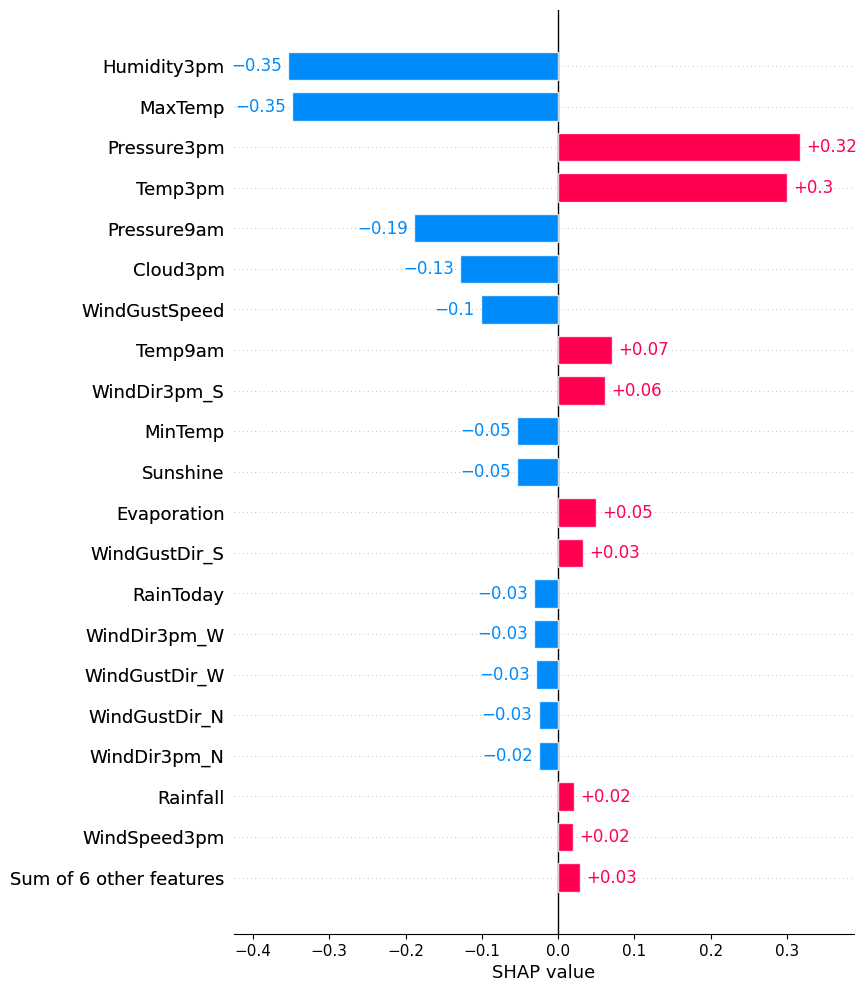

In [1809]:
# Crear la explicación para la instancia específica
explanation = shap.Explanation(values=shap_values, base_values=expected_value, feature_names=feature_names)

# Visualizar la explicación
shap.initjs()
shap.plots.bar(explanation, max_display=21)

De forma **Local** las varaibles que mas importancia tienen son MaxTemp, Humidity3pm, Pressure3pm y Temp3pm.

##### Explicabilidad Global

In [1810]:
instance_to_explain = X_train.sample(100)  

# Calcular los valores SHAP para los datos de prueba
shap_values = explainer.shap_values(instance_to_explain)

100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


In [1811]:
shap_values_squeezed = np.squeeze(shap_values)
feature_names = X_test.columns.values

In [1812]:
# Obtener el valor esperado (base value)
expected_value = explainer.expected_value

explanation = shap.Explanation(values=shap_values_squeezed, base_values=expected_value[0], feature_names=feature_names)

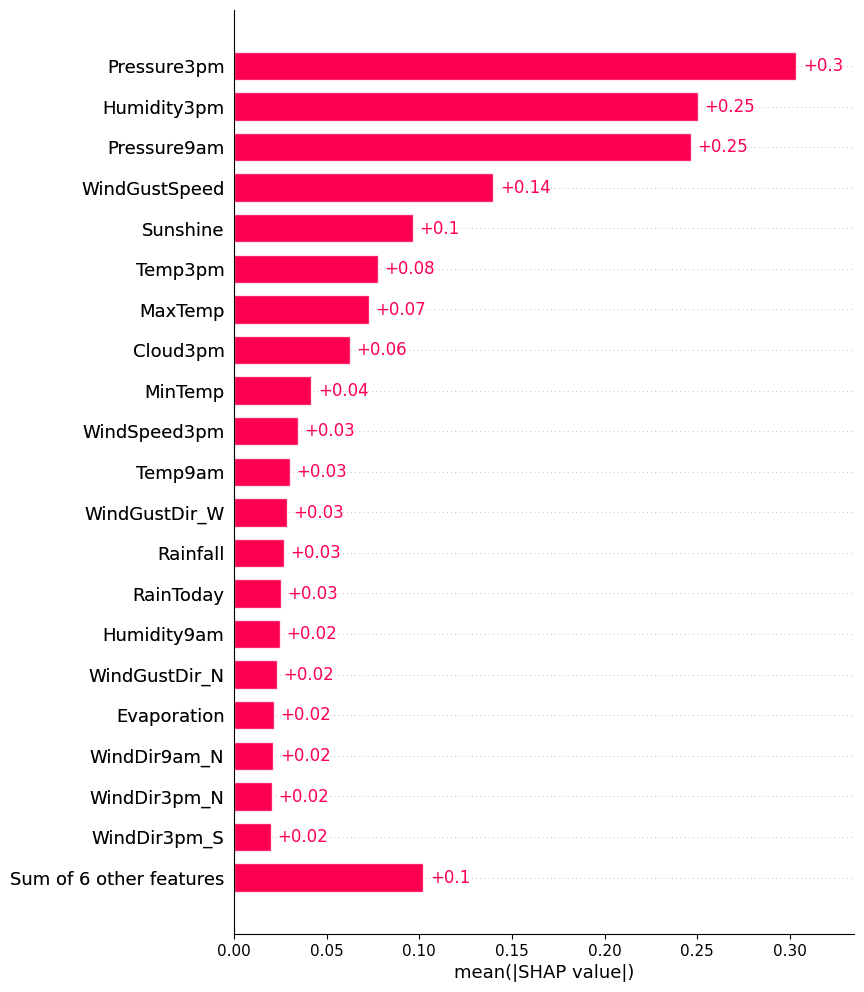

In [1813]:
# Visualizar la explicación
shap.initjs()
shap.plots.bar(explanation, max_display=21)

Las variables que mas aportan a la explicabilidad **Global** de mi modelo de redes neuronales son Pressure3pm, Pressure9am, Humidity3pm y WindSpeed3pm.

##### Conclusiones

| Modelo | Conjunto | MSE | 
|---------|---------|---------|
| Regresion Lineal | Train | 0.7837 |
| Regresion Lineal | Test | 0.9325 |
| Primer modelo de Redes Neuronales | Train | 0.8186 |
| Primer modelo de Redes Neuronales | Test | 1.0047 |
| Redes neuronales con hiperparámetros optimizados | Train | 0.6061 |

El modelo de redes neuronales con hiperparámetros optimizados ha logrado una reducción significativa en el MSE tanto en el conjunto de entrenamiento como en el de prueba, superando al modelo de regresión lineal y al primer modelo de redes neuronales.

El MSE en el conjunto de prueba es bastante cercano al del conjunto de entrenamiento, lo que sugiere que el modelo está generalizando bien sin sobreajustarse.

### RainTomorrow

##### Optimizacion de Hiperparametros

In [1814]:
# Función objective para Optuna
def objective(trial):

    num_layers = trial.suggest_int('num_layers', 1, 3)
    model = Sequential()

    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 4, 128)  # Neuronas en cada capa
        model.add(Dense(num_units, activation='relu'))  # Capas densas con activación ReLU

    # Capa de salida
    model.add(Dense(1, activation='sigmoid'))  # Capa de salida para clasificación binaria

    # Compilar el modelo
    model.compile(optimizer='adam', loss='binary_crossentropy')

    # Sugerir el número de epochs como hiperparámetro
    epochs = trial.suggest_int('epochs', 5, 50)

    # Entrenar el modelo
    model.fit(X_train_rl, y_train_rl, validation_data=(X_test_rl, y_test_rl), epochs=epochs, batch_size=32, verbose=0)

    # Realizar predicciones en el conjunto de prueba
    predictions = model.predict(X_test_rl)
    predictions_binary = np.where(predictions > 0.5, 1, 0)

    # Calcular el F1-Score
    f1 = f1_score(y_test_rl, predictions_binary)

    return f1

In [1815]:
# Crear un estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-08-04 15:17:09,975] A new study created in memory with name: no-name-ecc5fbac-4dba-43b0-a23f-385e26fb983e


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


[I 2024-08-04 15:17:28,618] Trial 0 finished with value: 0.608646188850967 and parameters: {'num_layers': 1, 'n_units_layer_0': 113, 'epochs': 42}. Best is trial 0 with value: 0.608646188850967.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step


[I 2024-08-04 15:17:41,601] Trial 1 finished with value: 0.6209896682979881 and parameters: {'num_layers': 1, 'n_units_layer_0': 42, 'epochs': 23}. Best is trial 1 with value: 0.6209896682979881.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step


[I 2024-08-04 15:17:56,634] Trial 2 finished with value: 0.6246122026887281 and parameters: {'num_layers': 2, 'n_units_layer_0': 51, 'n_units_layer_1': 83, 'epochs': 20}. Best is trial 2 with value: 0.6246122026887281.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


[I 2024-08-04 15:18:17,650] Trial 3 finished with value: 0.6334371754932503 and parameters: {'num_layers': 1, 'n_units_layer_0': 57, 'epochs': 33}. Best is trial 3 with value: 0.6334371754932503.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-08-04 15:18:47,415] Trial 4 finished with value: 0.5732758620689655 and parameters: {'num_layers': 3, 'n_units_layer_0': 22, 'n_units_layer_1': 100, 'n_units_layer_2': 69, 'epochs': 40}. Best is trial 3 with value: 0.6334371754932503.


136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 712us/step


[I 2024-08-04 15:19:10,679] Trial 5 finished with value: 0.5523226135783563 and parameters: {'num_layers': 3, 'n_units_layer_0': 93, 'n_units_layer_1': 118, 'n_units_layer_2': 20, 'epochs': 34}. Best is trial 3 with value: 0.6334371754932503.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step


[I 2024-08-04 15:19:31,630] Trial 6 finished with value: 0.63579604578564 and parameters: {'num_layers': 1, 'n_units_layer_0': 57, 'epochs': 44}. Best is trial 6 with value: 0.63579604578564.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step


[I 2024-08-04 15:19:56,196] Trial 7 finished with value: 0.5822784810126582 and parameters: {'num_layers': 2, 'n_units_layer_0': 46, 'n_units_layer_1': 104, 'epochs': 50}. Best is trial 6 with value: 0.63579604578564.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


[I 2024-08-04 15:20:20,336] Trial 8 finished with value: 0.5898305084745763 and parameters: {'num_layers': 3, 'n_units_layer_0': 40, 'n_units_layer_1': 7, 'n_units_layer_2': 35, 'epochs': 42}. Best is trial 6 with value: 0.63579604578564.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step


[I 2024-08-04 15:20:43,678] Trial 9 finished with value: 0.592964824120603 and parameters: {'num_layers': 3, 'n_units_layer_0': 9, 'n_units_layer_1': 87, 'n_units_layer_2': 44, 'epochs': 41}. Best is trial 6 with value: 0.63579604578564.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step


[I 2024-08-04 15:20:46,810] Trial 10 finished with value: 0.6381201044386423 and parameters: {'num_layers': 1, 'n_units_layer_0': 79, 'epochs': 5}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


[I 2024-08-04 15:20:50,476] Trial 11 finished with value: 0.6072607260726073 and parameters: {'num_layers': 1, 'n_units_layer_0': 79, 'epochs': 6}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


[I 2024-08-04 15:20:54,009] Trial 12 finished with value: 0.598531902879729 and parameters: {'num_layers': 2, 'n_units_layer_0': 73, 'n_units_layer_1': 36, 'epochs': 5}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step


[I 2024-08-04 15:21:00,739] Trial 13 finished with value: 0.6237837837837837 and parameters: {'num_layers': 1, 'n_units_layer_0': 104, 'epochs': 14}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-08-04 15:21:21,642] Trial 14 finished with value: 0.6201716738197425 and parameters: {'num_layers': 1, 'n_units_layer_0': 127, 'epochs': 50}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step


[I 2024-08-04 15:21:32,808] Trial 15 finished with value: 0.6057268722466961 and parameters: {'num_layers': 2, 'n_units_layer_0': 85, 'n_units_layer_1': 50, 'epochs': 16}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step


[I 2024-08-04 15:21:46,307] Trial 16 finished with value: 0.6128668171557562 and parameters: {'num_layers': 1, 'n_units_layer_0': 63, 'epochs': 28}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step


[I 2024-08-04 15:21:54,790] Trial 17 finished with value: 0.6 and parameters: {'num_layers': 2, 'n_units_layer_0': 30, 'n_units_layer_1': 4, 'epochs': 14}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step


[I 2024-08-04 15:22:09,307] Trial 18 finished with value: 0.6089417091114884 and parameters: {'num_layers': 1, 'n_units_layer_0': 67, 'epochs': 29}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step


[I 2024-08-04 15:22:14,923] Trial 19 finished with value: 0.5907764156450671 and parameters: {'num_layers': 2, 'n_units_layer_0': 90, 'n_units_layer_1': 62, 'epochs': 9}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step


[I 2024-08-04 15:22:24,840] Trial 20 finished with value: 0.5964705882352941 and parameters: {'num_layers': 1, 'n_units_layer_0': 104, 'epochs': 22}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step


[I 2024-08-04 15:22:39,655] Trial 21 finished with value: 0.6120042872454448 and parameters: {'num_layers': 1, 'n_units_layer_0': 56, 'epochs': 36}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-08-04 15:22:53,871] Trial 22 finished with value: 0.629863301787592 and parameters: {'num_layers': 1, 'n_units_layer_0': 62, 'epochs': 33}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step


[I 2024-08-04 15:23:16,104] Trial 23 finished with value: 0.6017410228509249 and parameters: {'num_layers': 1, 'n_units_layer_0': 77, 'epochs': 47}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step


[I 2024-08-04 15:23:31,598] Trial 24 finished with value: 0.6083102493074792 and parameters: {'num_layers': 1, 'n_units_layer_0': 29, 'epochs': 37}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step


[I 2024-08-04 15:23:55,668] Trial 25 finished with value: 0.62486602357985 and parameters: {'num_layers': 1, 'n_units_layer_0': 57, 'epochs': 46}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step


[I 2024-08-04 15:24:08,467] Trial 26 finished with value: 0.608649225840897 and parameters: {'num_layers': 2, 'n_units_layer_0': 70, 'n_units_layer_1': 29, 'epochs': 26}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step


[I 2024-08-04 15:24:26,467] Trial 27 finished with value: 0.6260869565217392 and parameters: {'num_layers': 1, 'n_units_layer_0': 34, 'epochs': 30}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step


[I 2024-08-04 15:24:47,966] Trial 28 finished with value: 0.6120401337792643 and parameters: {'num_layers': 1, 'n_units_layer_0': 17, 'epochs': 45}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step


[I 2024-08-04 15:25:07,066] Trial 29 finished with value: 0.5865002836074872 and parameters: {'num_layers': 1, 'n_units_layer_0': 98, 'epochs': 38}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step


[I 2024-08-04 15:25:25,264] Trial 30 finished with value: 0.60882800608828 and parameters: {'num_layers': 2, 'n_units_layer_0': 81, 'n_units_layer_1': 126, 'epochs': 33}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step


[I 2024-08-04 15:25:44,013] Trial 31 finished with value: 0.6253284287966369 and parameters: {'num_layers': 1, 'n_units_layer_0': 63, 'epochs': 33}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step


[I 2024-08-04 15:26:00,555] Trial 32 finished with value: 0.6306878306878307 and parameters: {'num_layers': 1, 'n_units_layer_0': 54, 'epochs': 32}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step


[I 2024-08-04 15:26:13,355] Trial 33 finished with value: 0.6118166758696852 and parameters: {'num_layers': 1, 'n_units_layer_0': 49, 'epochs': 25}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step


[I 2024-08-04 15:26:30,284] Trial 34 finished with value: 0.6062291434927698 and parameters: {'num_layers': 1, 'n_units_layer_0': 53, 'epochs': 31}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step


[I 2024-08-04 15:26:39,070] Trial 35 finished with value: 0.6117775354416576 and parameters: {'num_layers': 1, 'n_units_layer_0': 39, 'epochs': 19}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step


[I 2024-08-04 15:26:58,727] Trial 36 finished with value: 0.6258722490606549 and parameters: {'num_layers': 1, 'n_units_layer_0': 46, 'epochs': 44}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-08-04 15:27:15,648] Trial 37 finished with value: 0.6273258904837852 and parameters: {'num_layers': 1, 'n_units_layer_0': 59, 'epochs': 39}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-08-04 15:27:29,215] Trial 38 finished with value: 0.586015538290788 and parameters: {'num_layers': 2, 'n_units_layer_0': 72, 'n_units_layer_1': 72, 'epochs': 23}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step


[I 2024-08-04 15:27:52,293] Trial 39 finished with value: 0.587117212249208 and parameters: {'num_layers': 3, 'n_units_layer_0': 42, 'n_units_layer_1': 24, 'n_units_layer_2': 124, 'epochs': 42}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step


[I 2024-08-04 15:27:58,408] Trial 40 finished with value: 0.6113292204150308 and parameters: {'num_layers': 2, 'n_units_layer_0': 87, 'n_units_layer_1': 48, 'epochs': 9}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step


[I 2024-08-04 15:28:14,124] Trial 41 finished with value: 0.6339662447257384 and parameters: {'num_layers': 1, 'n_units_layer_0': 63, 'epochs': 35}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


[I 2024-08-04 15:28:30,873] Trial 42 finished with value: 0.6206896551724138 and parameters: {'num_layers': 1, 'n_units_layer_0': 48, 'epochs': 35}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-08-04 15:28:44,478] Trial 43 finished with value: 0.6092789267747345 and parameters: {'num_layers': 1, 'n_units_layer_0': 76, 'epochs': 31}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step


[I 2024-08-04 15:29:01,505] Trial 44 finished with value: 0.6208401527550463 and parameters: {'num_layers': 1, 'n_units_layer_0': 67, 'epochs': 40}. Best is trial 10 with value: 0.6381201044386423.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step


[I 2024-08-04 15:29:13,229] Trial 45 finished with value: 0.6433282597666159 and parameters: {'num_layers': 1, 'n_units_layer_0': 57, 'epochs': 26}. Best is trial 45 with value: 0.6433282597666159.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step


[I 2024-08-04 15:29:21,659] Trial 46 finished with value: 0.5950885208452313 and parameters: {'num_layers': 1, 'n_units_layer_0': 84, 'epochs': 18}. Best is trial 45 with value: 0.6433282597666159.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step


[I 2024-08-04 15:29:42,406] Trial 47 finished with value: 0.5868544600938967 and parameters: {'num_layers': 1, 'n_units_layer_0': 95, 'epochs': 48}. Best is trial 45 with value: 0.6433282597666159.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step


[I 2024-08-04 15:30:01,463] Trial 48 finished with value: 0.6134499726626572 and parameters: {'num_layers': 1, 'n_units_layer_0': 69, 'epochs': 43}. Best is trial 45 with value: 0.6433282597666159.


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-08-04 15:30:07,291] Trial 49 finished with value: 0.6153846153846154 and parameters: {'num_layers': 1, 'n_units_layer_0': 122, 'epochs': 10}. Best is trial 45 with value: 0.6433282597666159.


In [1816]:
# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores parámetros encontrados:", best_params)

Mejores parámetros encontrados: {'num_layers': 1, 'n_units_layer_0': 57, 'epochs': 26}


Mejores parámetros encontrados: {'num_layers': 2, 'n_units_layer_0': 43, 'n_units_layer_1': 96, 'epochs': 17}

In [1817]:
class NeuralNetworkTensorFlowRl:
    def __init__(self, batch_size=32, epochs=10, learning_rate=0.001, dropout_rate=0.3, n_units_layer_0=64, n_units_layer_1=32):
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.n_units_layer_0 = n_units_layer_0
        self.n_units_layer_1 = n_units_layer_1
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential()

        # Capa 1 con Dropout
        model.add(tf.keras.layers.Dense(self.n_units_layer_0, activation='relu', input_shape=(X_train_rl.shape[1],)))
        model.add(tf.keras.layers.Dropout(self.dropout_rate))  # Dropout

        # Capa 2 con Dropout
        model.add(tf.keras.layers.Dense(self.n_units_layer_1, activation='relu'))
        model.add(tf.keras.layers.Dropout(self.dropout_rate))  # Dropout

        # Capa de salida
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        # Compilación del modelo con la métrica de F1-Score personalizada
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), 
                      loss='binary_crossentropy', 
                      metrics=[self.f1_score_custom_v2])
        return model

    def f1_score_custom_v2(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)  # Asegurarse de que y_true sea float32
        y_pred_bin = tf.cast(tf.where(y_pred > 0.5, 1.0, 0.0), tf.float32)  # Convertir y_pred a float32 después de binarizarlo

        true_positives = tf.reduce_sum(tf.multiply(y_true, y_pred_bin))
        false_positives = tf.reduce_sum(tf.multiply(1.0 - y_true, y_pred_bin))
        false_negatives = tf.reduce_sum(tf.multiply(y_true, 1.0 - y_pred_bin))

        precision_value = true_positives / (true_positives + false_positives + tf.keras.backend.epsilon())
        recall_value = true_positives / (true_positives + false_negatives + tf.keras.backend.epsilon())

        f1_score_result = tf.where(
            tf.equal(precision_value + recall_value, 0.0),
            0.0,
            2 * precision_value * recall_value / (precision_value + recall_value + tf.keras.backend.epsilon())
        )
        
        return f1_score_result

    def fit(self, X, y, X_val=None, y_val=None):
        X = np.array(X)
        y = np.array(y)
        
        # Convertir los datos de validación a numpy si es necesario
        if isinstance(X_val, tf.Tensor):
            X_val = X_val.numpy()
        if isinstance(y_val, tf.Tensor):
            y_val = y_val.numpy()

        # Listas para almacenar las pérdidas por cada época
        losses = []
        
        for epoch in range(self.epochs):
            # Entrenar el modelo por una época y guardar la pérdida
            history = self.model.fit(X, y, epochs=1, batch_size=self.batch_size, verbose=0)
            losses.append(history.history['loss'][0])

            # Al final de cada época, calcular el F1-Score en los datos de validación
            if X_val is not None and y_val is not None:
                val_y_pred = self.model.predict(X_val)
                val_y_pred_bin = (val_y_pred > 0.5).astype(int)
                
                f1_value = sklearn_f1_score(y_val, val_y_pred_bin, average='weighted')
                print(f'Epoch {epoch + 1}/{self.epochs}: F1-Score en validación: {f1_value:.4f}')

        return losses

    def predict(self, X):
        X = np.array(X)
        predictions = self.model.predict(X)
        return predictions

In [1818]:
# Instanciar y entrenar el modelo
nn_model_rl = NeuralNetworkTensorFlowRl(batch_size=32, epochs=17, learning_rate=0.001, dropout_rate=0.3, n_units_layer_0=43, n_units_layer_1=96)
nn_model_rl.fit(X_train_rl, y_train_rl, X_test_rl, y_test_rl)

c:\Users\Francisco\Desktop\AA1-TUIA-RodriguezYBarros\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/17: F1-Score en validación: 0.8196
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step
Epoch 2/17: F1-Score en validación: 0.8169
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step
Epoch 3/17: F1-Score en validación: 0.8155
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step
Epoch 4/17: F1-Score en validación: 0.8184
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step
Epoch 5/17: F1-Score en validación: 0.8156
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
Epoch 6/17: F1-Score en validación: 0.8171
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
Epoch 7/17: F1-Score en validación: 0.8162
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step
Epoch 8/17: F1-Score en validación: 0.8149
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
Epoch 9/17: F1-Score en validación: 0.8238
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step
Epoch 10/17: F1-Score en validación: 0.8203
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
Epoch 11/17: F1-Score en validación: 0.8169
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
Epoch 12/17

[0.4101696312427521,
 0.37985503673553467,
 0.37004542350769043,
 0.36687004566192627,
 0.36296260356903076,
 0.3584870398044586,
 0.3586711287498474,
 0.35632896423339844,
 0.3551488518714905,
 0.35364633798599243,
 0.35253098607063293,
 0.352409303188324,
 0.3506932556629181,
 0.34816890954971313,
 0.3493913412094116,
 0.34904277324676514,
 0.3469899296760559]

In [1819]:
# Predicciones en el conjunto de Train y Test
y_pred_train = nn_model_rl.predict(X_train_rl)
y_pred_test = nn_model_rl.predict(X_test_rl)

# Predicciones a etiquetas binarias
y_pred_train_binary = (y_pred_train > 0.5).astype(int)
y_pred_test_binary = (y_pred_test > 0.5).astype(int)

# F1-Score Train
f1_score_train = sklearn_f1_score(y_train_rl, y_pred_train_binary, average='weighted')
print(f"F1 Score en el conjunto de entrenamiento: {f1_score_train}")

# F1-Score test
f1_score_test = sklearn_f1_score(y_test_rl, y_pred_test_binary, average='weighted')
print(f"F1 Score en el conjunto de prueba: {f1_score_test}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step
F1 Score en el conjunto de entrenamiento: 0.8416719138114873
F1 Score en el conjunto de prueba: 0.8172058714891866


##### Explicabilidad local

In [1820]:
# Crear un conjunto de muestras de fondo
background = X_train_rl.sample(100) 
explainer = shap.KernelExplainer(nn_model_rl.model.predict, background)  # Usar una muestra del conjunto de entrenamiento


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


In [1821]:
instance_to_explain = X_test_rl.iloc[0:1].values  # Seleccionar la línea 0

# Calcular los valores SHAP para los datos de prueba
shap_values = explainer.shap_values(instance_to_explain)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6563/6563 ━━━━━━━━━━━━━━━━━━━━ 3s 451us/step


100%|██████████| 1/1 [00:05<00:00,  5.04s/it]


In [1822]:
# Obtener el valor esperado (base value)
expected_value = explainer.expected_value

# Hacer predicciones
index = 0  # índice de la instancia que queremos explicar
predicted_proba = nn_model_rl.predict(X_test_rl)[index]  # Predicción de probabilidad
predicted_class = np.argmax(predicted_proba)  # Clase predicha

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step


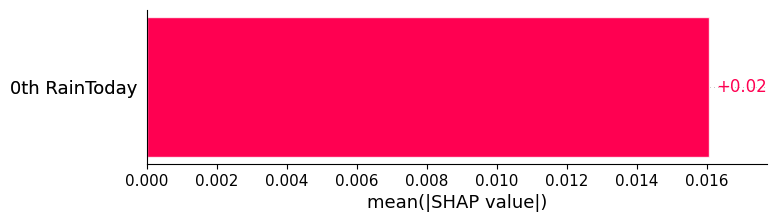

In [1823]:
# Crear la explicación para la instancia específica
explanation = shap.Explanation(values=shap_values[0], base_values=expected_value, feature_names=feature_names)

# Visualizar la explicación
shap.initjs()
shap.plots.bar(explanation, max_display=len(feature_names))